
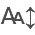

In [1]:
import yaml
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itables import show
from itables import init_notebook_mode
from requests_oauthlib import OAuth2Session
from pandas.io.json import json_normalize
import re
#import swagger_client
#from swagger_client.rest import ApiException
from pprint import pprint
import time
from datetime import datetime
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap

#set max rows and columns displayed
pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', 250)

#set options for itables
init_notebook_mode(all_interactive=True)

#set color palette
#plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette('Set1'))
# Set the color palette using rcParams
sns.set_palette("colorblind")
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette("colorblind"))
# Set rcParams for axis labels and tick labels
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 20  # Set the title size to 20pt

%matplotlib inline

# Overview

Look at Strava data over the last 4 years to look at trends and improvements.

1. read in cleaned file
2. Calculate weekly, monthly and quarterly time.
3. Look at workout counts- is there a shift in number or minutes for workout types?
4. Focus on bike
    1. Trends over time
    2. Minutes and power output on same graph
5. Weightlifting minutes

In [29]:
# read in datafile
df=pd.read_csv('../data/cleaned_small_data.csv')
show(df)

In [30]:
#look at dtypes
show(df.dtypes)

In [31]:
#convert start_date to datetime
# Convert 'start_date' to datetime
df['start_date'] = pd.to_datetime(df['start_date'])

In [32]:
df['year'] = pd.to_datetime(df['start_date']).dt.year
show(df)

<Figure size 1200x600 with 0 Axes>

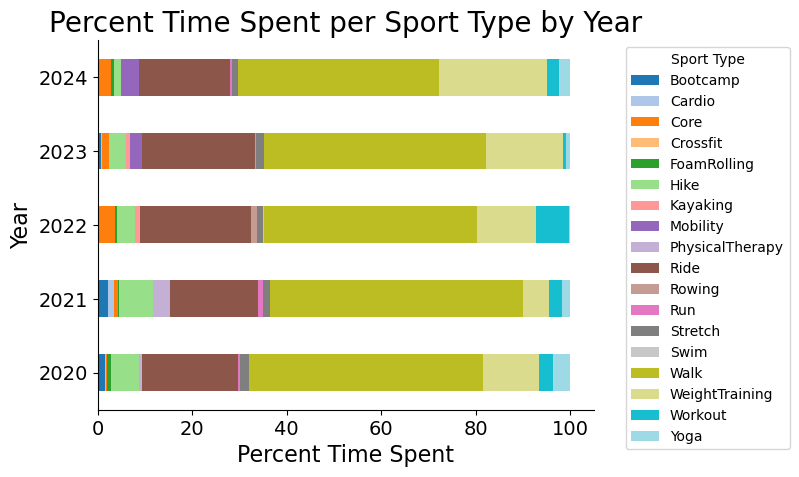

In [46]:
plt.figure(figsize=(12,6))
# Calculate the total moving time per year
total_time_per_year = df.groupby('year')['moving_time'].sum()

# Calculate the total moving time per sport_type per year
time_per_sport_type_per_year = df.groupby(['year', 'sport_type'])['moving_time'].sum().unstack().fillna(0)

# Calculate the percentage time spent per sport_type per year
percent_time_per_sport_type_per_year = time_per_sport_type_per_year.div(total_time_per_year, axis=0) * 100

# Plot the horizontal stacked bar chart
percent_time_per_sport_type_per_year.plot(kind='barh', stacked=True, colormap='tab20')

plt.xlabel('Percent Time Spent')
plt.ylabel('Year')
plt.title('Percent Time Spent per Sport Type by Year')
plt.legend(title='Sport Type', bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine(top=True, right=True)
plt.savefig('../presentations/pictures/total_time_active_per_year_by_activity.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 1200x600 with 0 Axes>

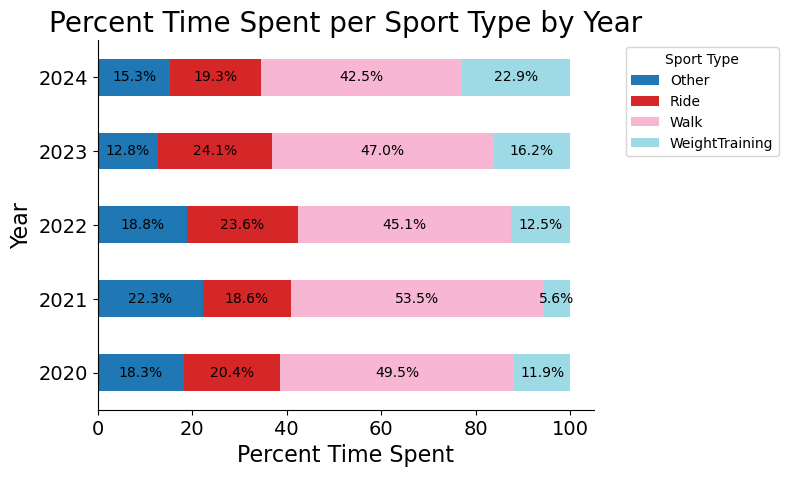

In [49]:
# Filter the dataframe to include only the specified sport types and lump others into 'Other'
df_filtered = df.copy()
df_filtered['sport_type'] = df_filtered['sport_type'].apply(lambda x: x if x in ['Walk', 'Ride', 'WeightTraining'] else 'Other')

# Calculate the total moving time per year
total_time_per_year = df_filtered.groupby('year')['moving_time'].sum()

# Calculate the total moving time per sport_type per year
time_per_sport_type_per_year = df_filtered.groupby(['year', 'sport_type'])['moving_time'].sum().unstack().fillna(0)

# Calculate the percentage time spent per sport_type per year
percent_time_per_sport_type_per_year = time_per_sport_type_per_year.div(total_time_per_year, axis=0) * 100

# Plot the horizontal stacked bar chart
plt.figure(figsize=(12, 6))
ax=percent_time_per_sport_type_per_year.plot(kind='barh', stacked=True, colormap='tab20')

# Add percentages inside the bars
for bars in ax.containers:
    ax.bar_label(bars, fmt='%.1f%%', label_type='center')

plt.xlabel('Percent Time Spent')
plt.ylabel('Year')
plt.title('Percent Time Spent per Sport Type by Year')
plt.legend(title='Sport Type', bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine(top=True, right=True)
plt.savefig('../presentations/pictures/percent_time_spent_per_sport_type_lumped.png', dpi=300, bbox_inches='tight')
plt.show()

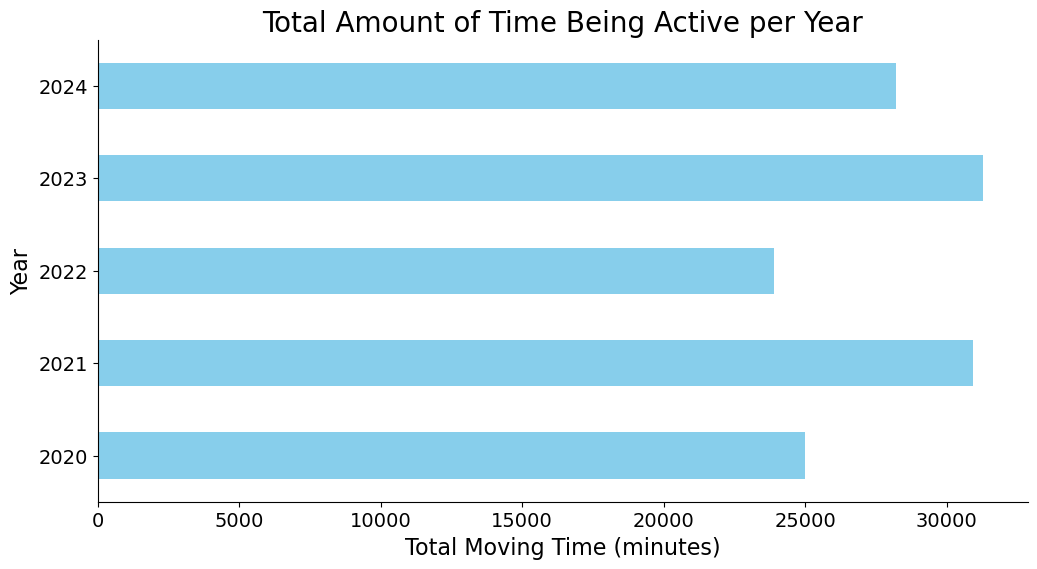

In [44]:
plt.figure(figsize=(12,6))
# Plot the horizontal bar chart for total amount of time being active
total_time_per_year.plot(kind='barh', color='skyblue')


plt.xlabel('Total Moving Time (minutes)')
plt.ylabel('Year')
plt.title('Total Amount of Time Being Active per Year')
sns.despine(top=True, right=True)
plt.savefig('../presentations/pictures/total_time_active_per_year.png', dpi=300, bbox_inches='tight')
plt.show()

In [5]:
# Identify all rows that have 'FTP' in the 'name' column
ftp_rows = df[df['name'].str.contains('FTP Test Ride', na=False)]
show(ftp_rows)

In [6]:
df_bike_inf=df[df['sport_type']=='Ride'].copy()
show(df_bike_inf)

In [7]:
def determine_ride_type(name):
    if 'Power Zone' in name or 'FTP' in name:
        return 'Power Zone'
    elif 'HIIT & Hills' in name:
        return 'HIIT&Hills'
    elif 'Low Impact' in name:
        return 'Low Impact'
    else:
        return 'Music/Theme'

df_bike_inf['ride_type'] = df_bike_inf['name'].apply(determine_ride_type)
show(df_bike_inf)

In [8]:
df_bike_inf['year'] = pd.to_datetime(df_bike_inf['start_date']).dt.year
show(df_bike_inf)

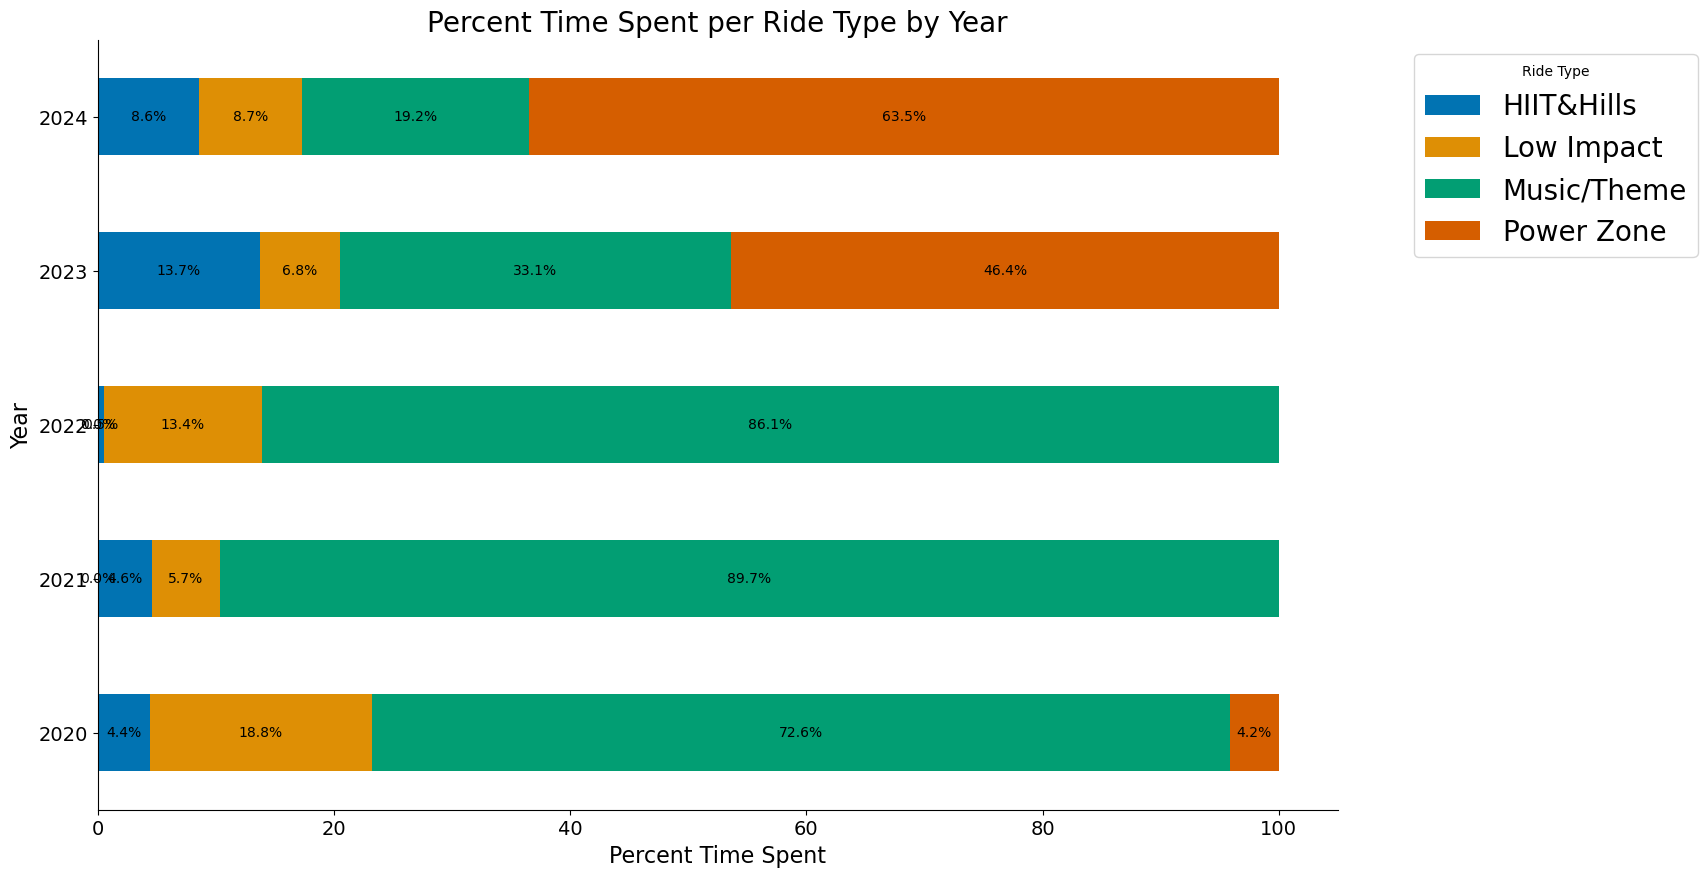

In [61]:
# Calculate the total moving time per year
total_time_per_year = df_bike_inf.groupby('year')['moving_time'].sum()

# Calculate the total moving time per ride_type per year
time_per_ride_type_per_year = df_bike_inf.groupby(['year', 'ride_type'])['moving_time'].sum().unstack().fillna(0)

# Calculate the percentage time spent per ride_type per year
percent_time_per_ride_type_per_year = time_per_ride_type_per_year.div(total_time_per_year, axis=0) * 100

# Plot the horizontal stacked bar chart
ax=percent_time_per_ride_type_per_year.plot(kind='barh', stacked=True, figsize=(16, 10))

# Add percentages inside the bars
for bars in ax.containers:
    ax.bar_label(bars, fmt='%.1f%%', label_type='center')

plt.xlabel('Percent Time Spent')
plt.ylabel('Year')
plt.title('Percent Time Spent per Ride Type by Year')
plt.legend(title='Ride Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='20')
sns.despine(top=True, right=True)
plt.savefig('../presentations/pictures/bike_types.png', dpi=300, bbox_inches='tight')
plt.show()

2023-01-14 21:39:12+00:00
2024-02-09 14:49:58+00:00


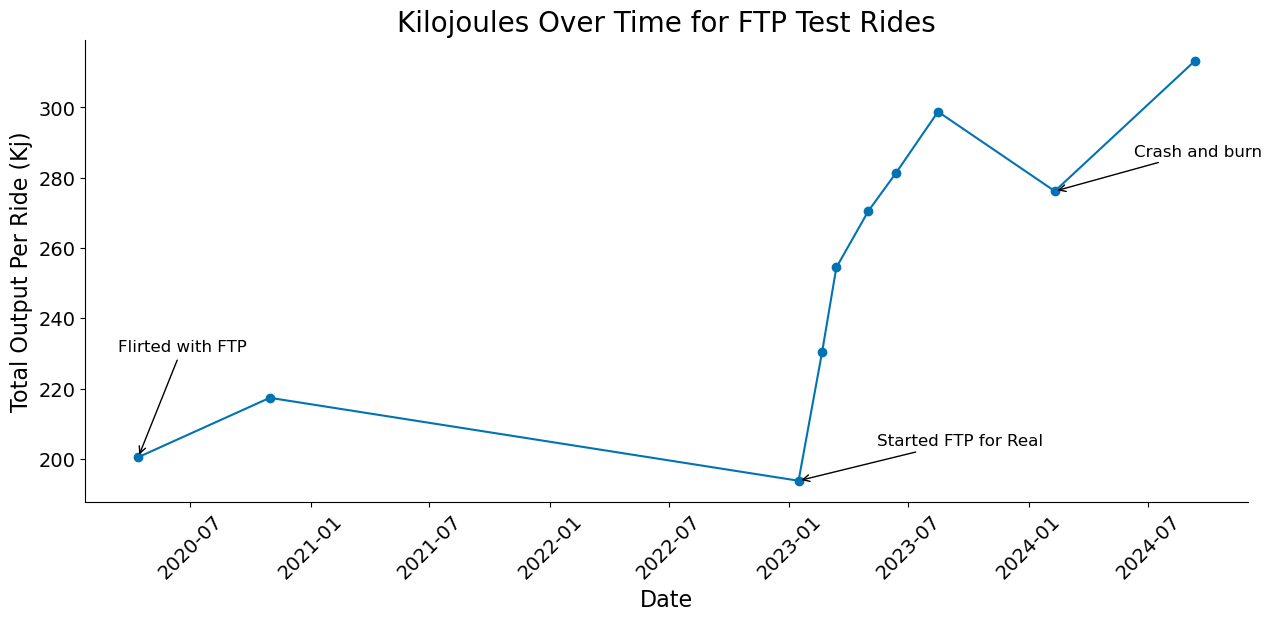

In [54]:
plt.figure(figsize=(15, 6))
plt.plot(ftp_rows['start_date'], ftp_rows['kilojoules'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Total Output Per Ride (Kj)')
plt.title('Kilojoules Over Time for FTP Test Rides')
plt.xticks(rotation=45)
sns.despine(right=True, top=True)
# Add annotations
first_date = ftp_rows['start_date'].iloc[-1]
first_kilojoules = ftp_rows['kilojoules'].iloc[-1]
plt.annotate('Flirted with FTP', xy=(first_date, first_kilojoules), 
             xytext=(first_date - pd.DateOffset(months=1), first_kilojoules + 30),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12)

specific_date = ftp_rows['start_date'].iloc[-3]
print(specific_date)
specific_kilojoules = ftp_rows['kilojoules'].iloc[-3]
plt.annotate('Started FTP for Real', xy=(specific_date, specific_kilojoules), 
             xytext=(specific_date - pd.DateOffset(months=-4), specific_kilojoules + 10),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12)

crash_date = ftp_rows['start_date'].iloc[1]
print(crash_date)
crash_kilojoules = ftp_rows['kilojoules'].iloc[1]
plt.annotate('Crash and burn', xy=(crash_date, crash_kilojoules), 
             xytext=(crash_date - pd.DateOffset(months=-4), crash_kilojoules + 10),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12)

plt.savefig('../presentations/pictures/ftp.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
# Weekly aggregate
df_weekly = df.groupby('sport_type').resample('W-Mon', on='start_date').agg({'moving_time': 'sum', 'kilojoules': 'sum'}).reset_index()
df_weekly['interval'] = df_weekly['start_date'].dt.strftime('%Y-W%U')
df_weekly['interval_date'] = pd.to_datetime(df_weekly['interval'] + '-1', format='%Y-W%U-%w')
df_weekly = df_weekly.sort_values(by=['sport_type', 'interval_date'])
df_weekly['cumsum_moving_time'] = df_weekly.groupby('sport_type')['moving_time'].cumsum()
df_weekly['cumsum_kilojoules'] = df_weekly.groupby('sport_type')['kilojoules'].cumsum()
df_weekly = df_weekly.drop(columns=['interval_date'])

# Monthly aggregate
df_monthly = df.groupby('sport_type').resample('M', on='start_date').agg({'moving_time': 'sum', 'kilojoules': 'sum'}).reset_index()
df_monthly['interval'] = df_monthly['start_date'].dt.to_period('M').astype(str)
df_monthly = df_monthly.sort_values(by=['sport_type', 'start_date'])
df_monthly['cumsum_moving_time'] = df_monthly.groupby('sport_type')['moving_time'].cumsum()
df_monthly['cumsum_kilojoules'] = df_monthly.groupby('sport_type')['kilojoules'].cumsum()

# Quarterly aggregate
df_quarterly = df.groupby('sport_type').resample('Q', on='start_date').agg({'moving_time': 'sum', 'kilojoules': 'sum'}).reset_index()
df_quarterly['interval'] = df_quarterly['start_date'].dt.to_period('Q').astype(str)
df_quarterly = df_quarterly.sort_values(by=['sport_type', 'start_date'])
df_quarterly['cumsum_moving_time'] = df_quarterly.groupby('sport_type')['moving_time'].cumsum()
df_quarterly['cumsum_kilojoules'] = df_quarterly.groupby('sport_type')['kilojoules'].cumsum()

# Display the dataframes
show(df_weekly)
show(df_monthly)
show(df_quarterly)

/var/folders/nc/8xd1vn2n62dgdsxxm4vzqjtm0000gn/T/ipykernel_64206/448109451.py:12: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_monthly['interval'] = df_monthly['start_date'].dt.to_period('M').astype(str)
/var/folders/nc/8xd1vn2n62dgdsxxm4vzqjtm0000gn/T/ipykernel_64206/448109451.py:19: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_quarterly['interval'] = df_quarterly['start_date'].dt.to_period('Q').astype(str)


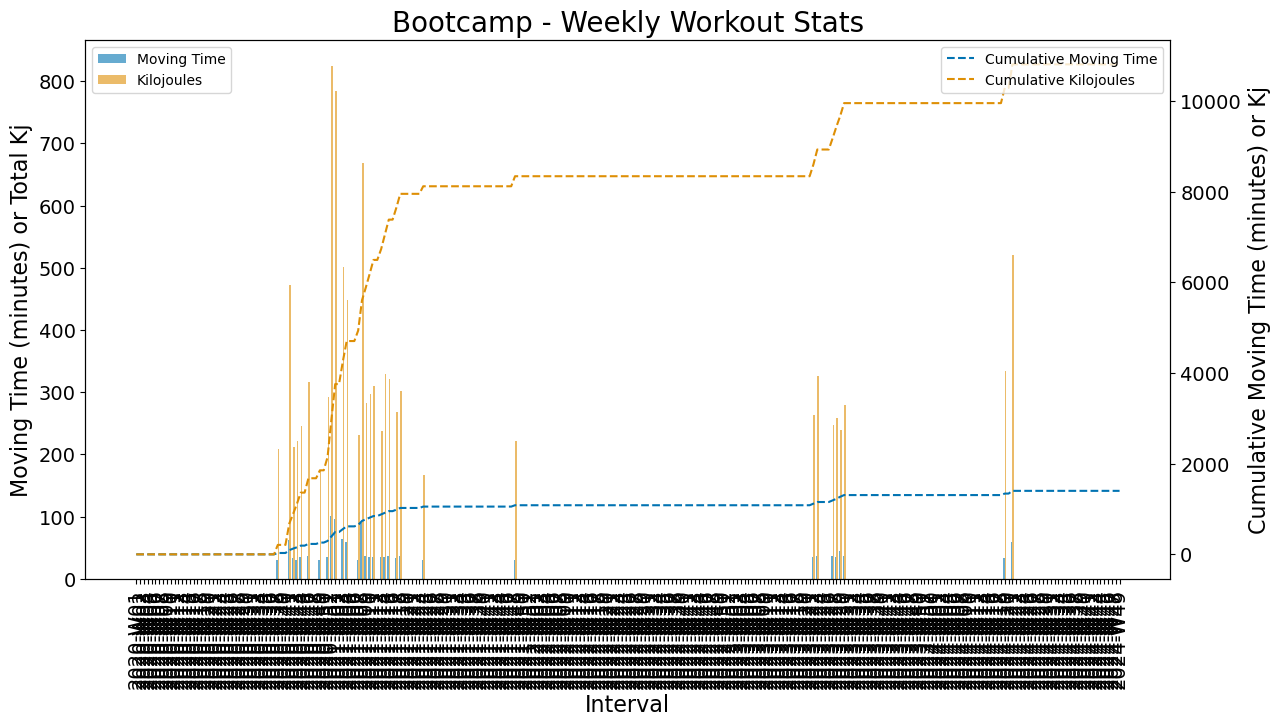

No Kilogoules


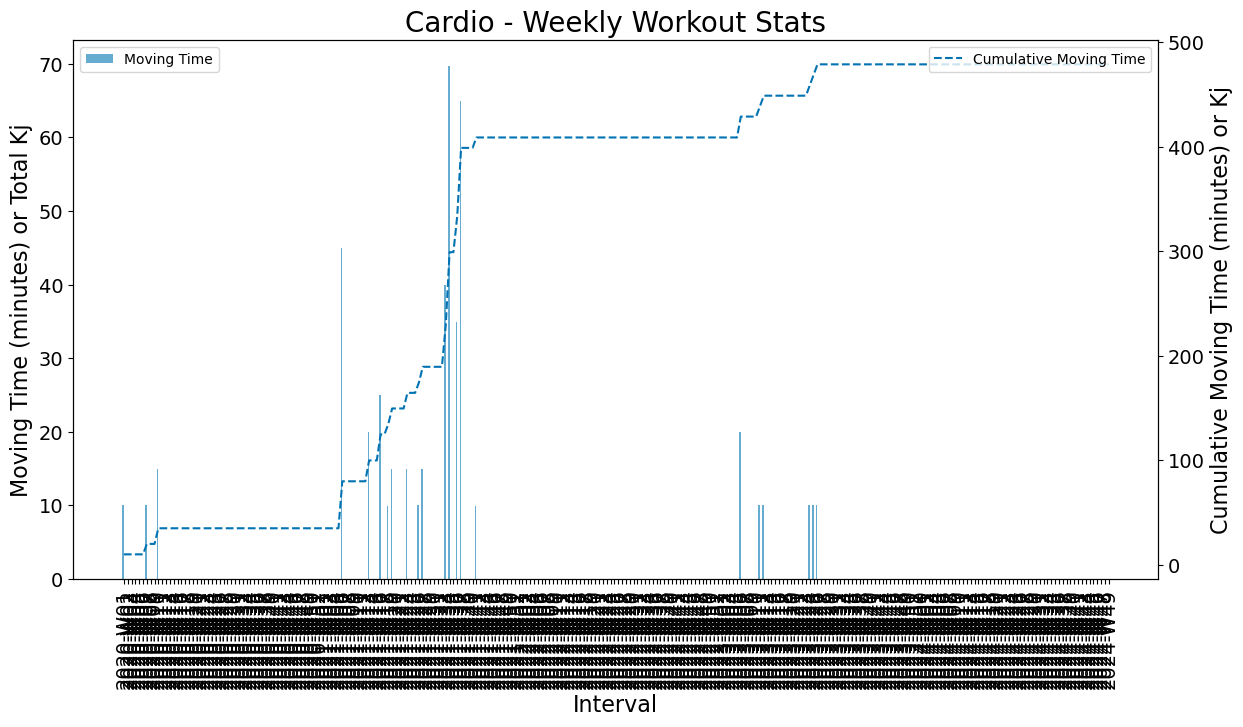

No Kilogoules


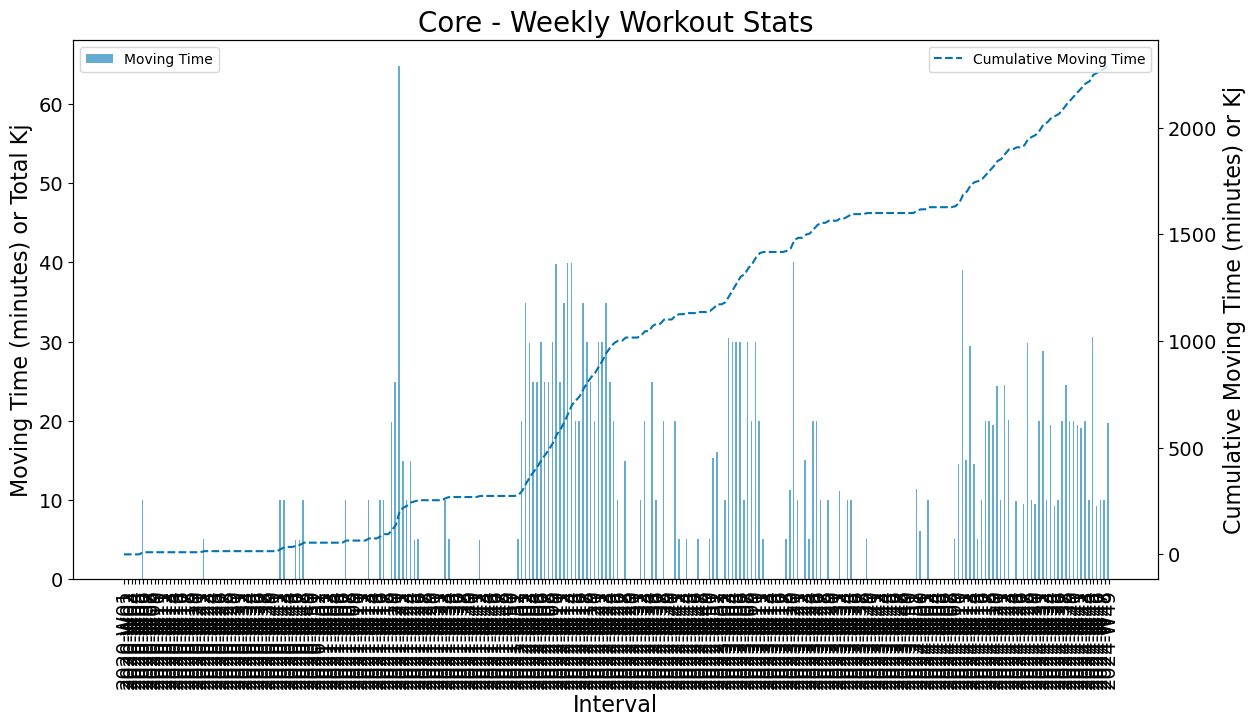

No Kilogoules


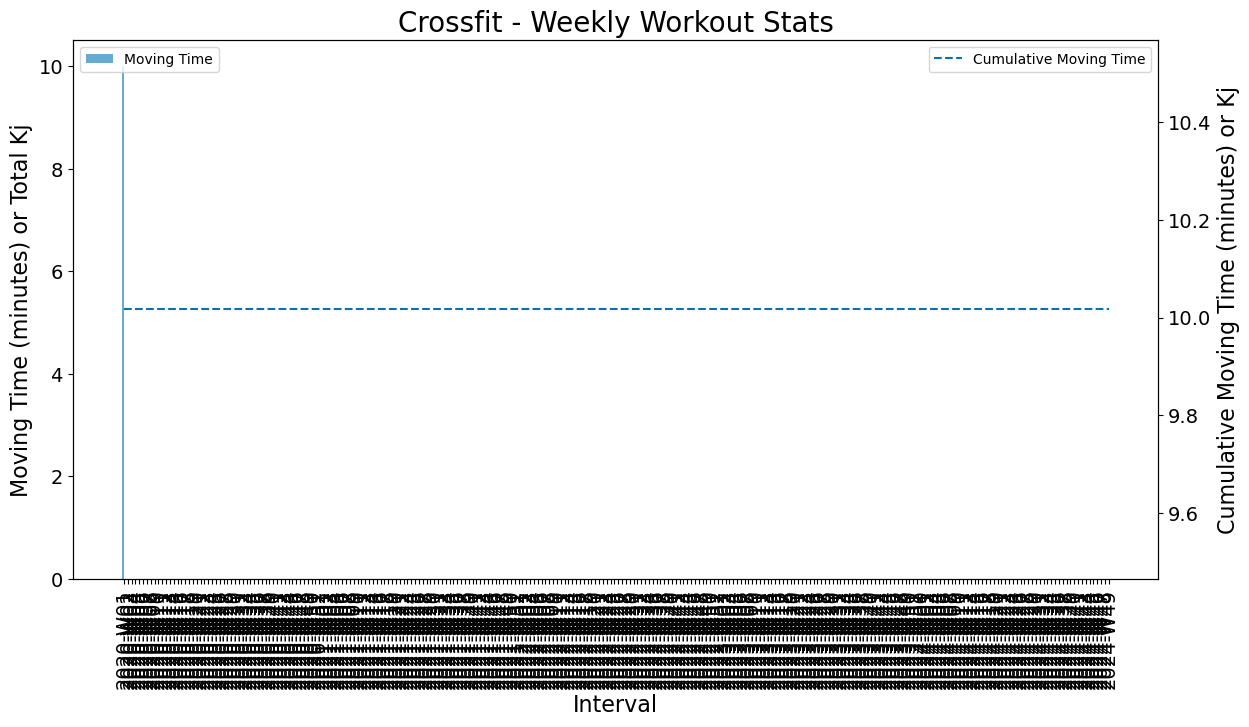

No Kilogoules


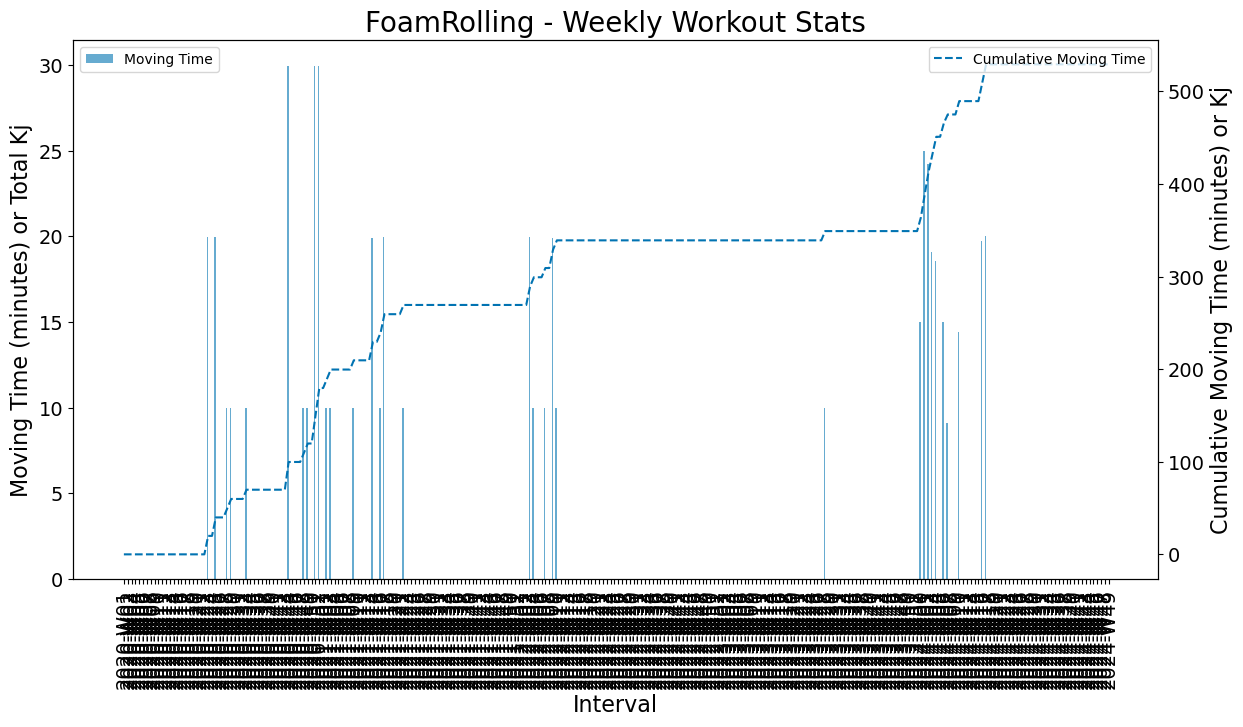

No Kilogoules


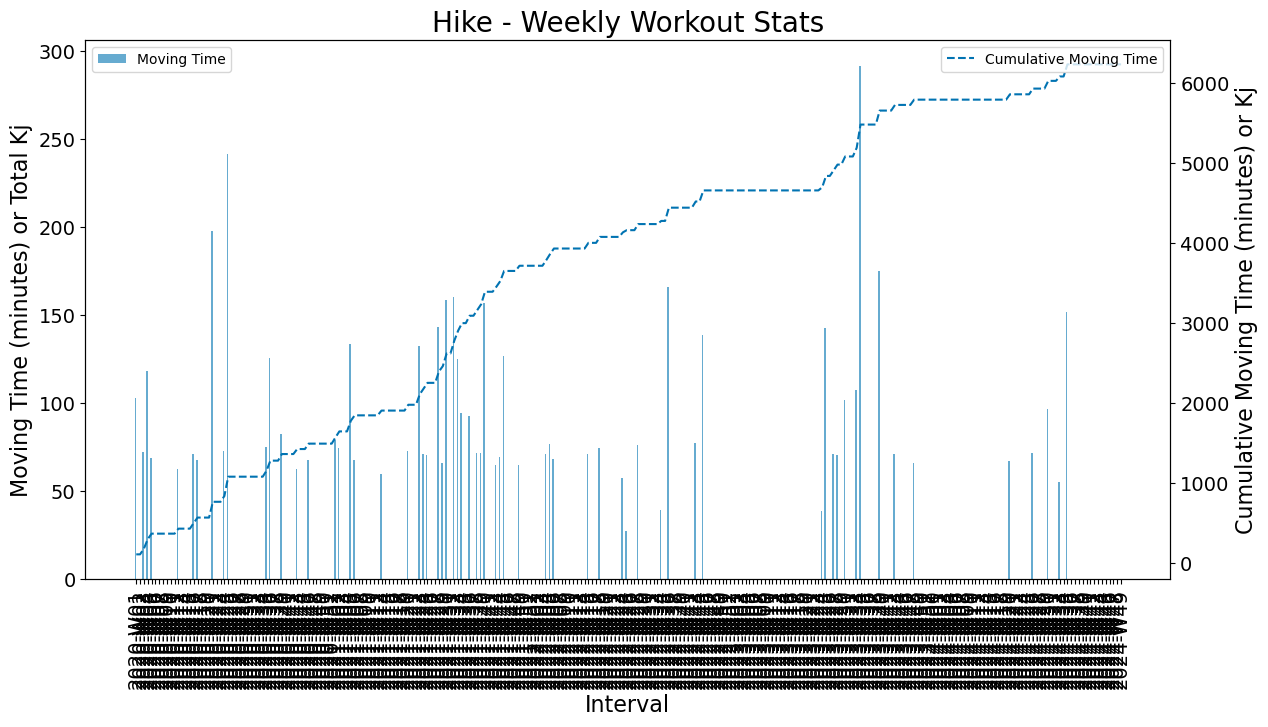

No Kilogoules


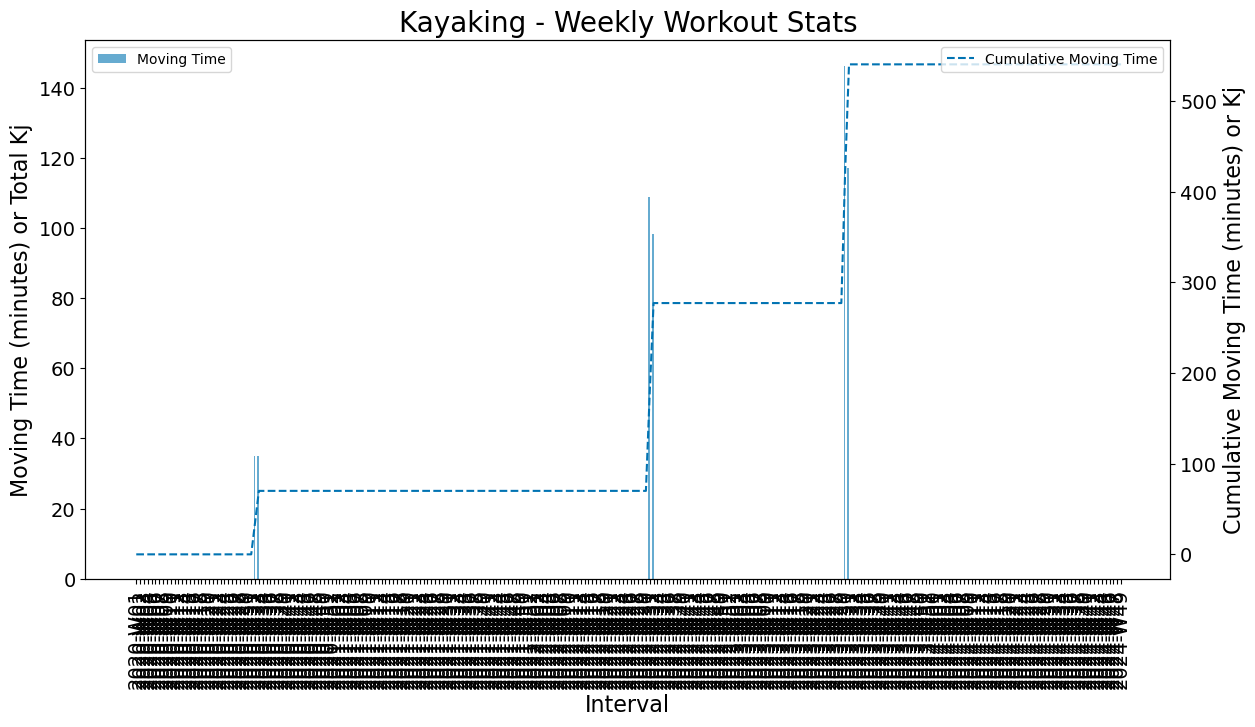

No Kilogoules


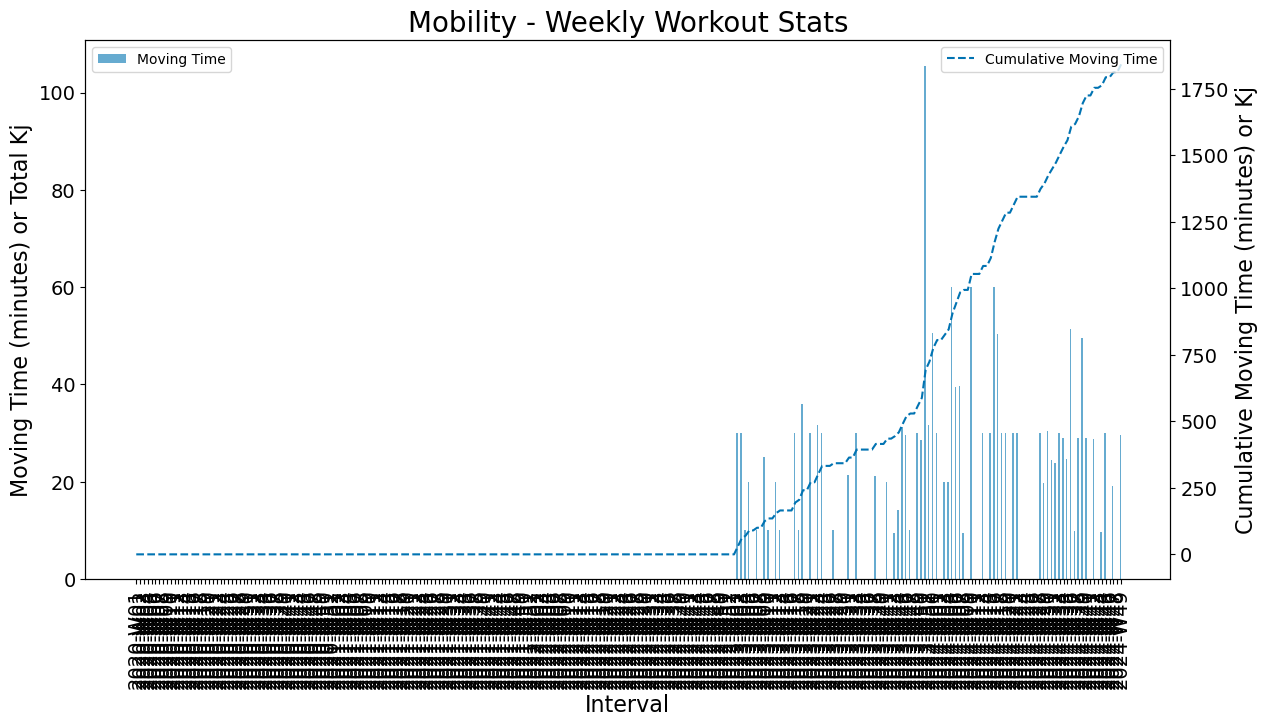

No Kilogoules


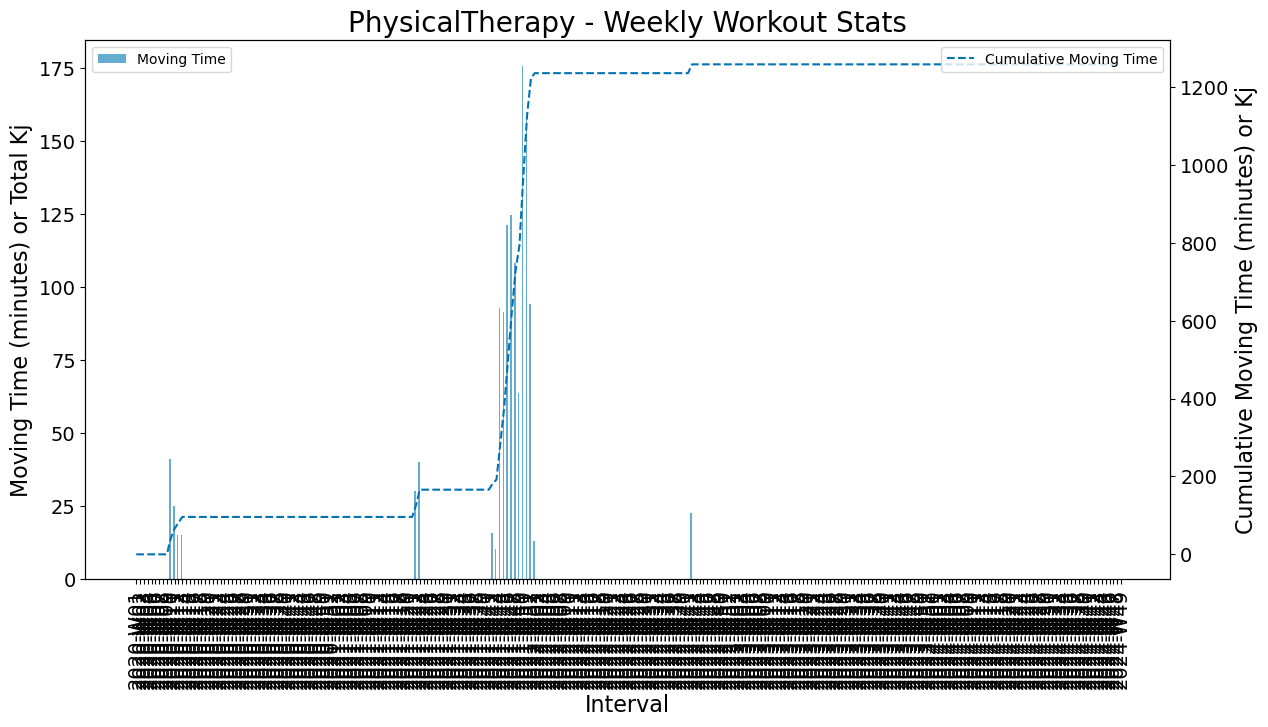

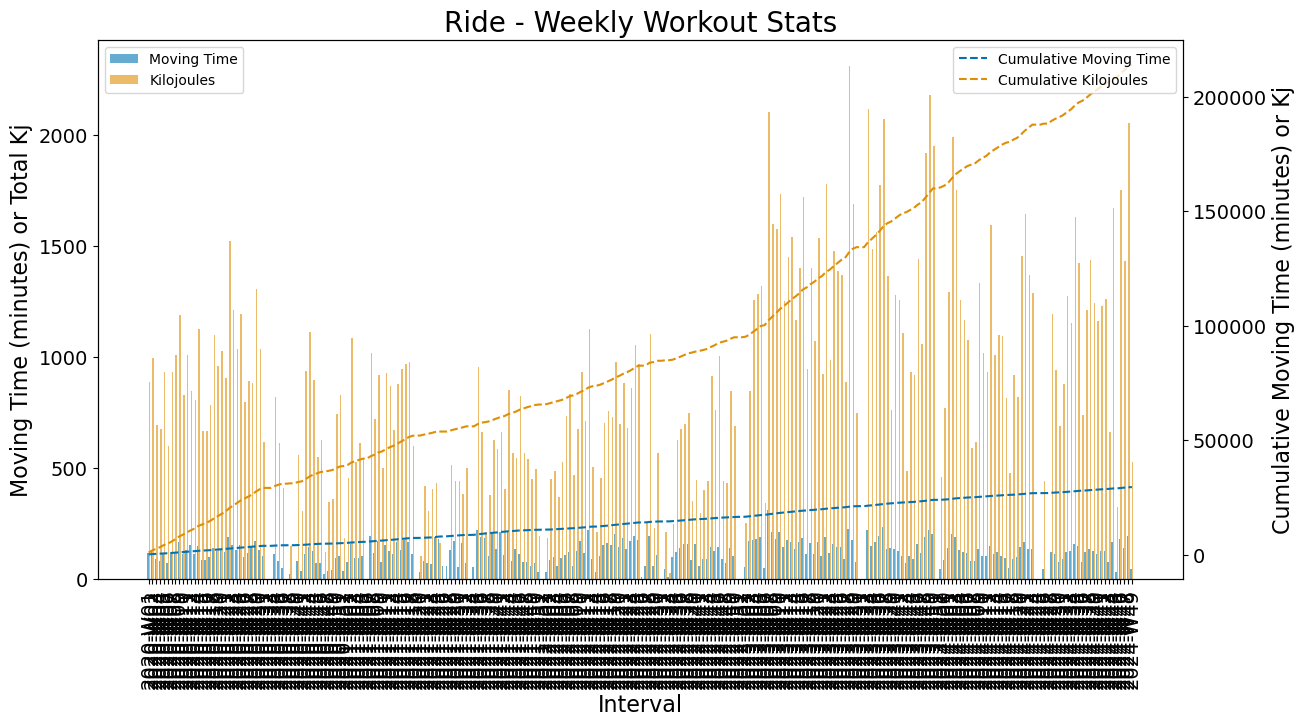

No Kilogoules


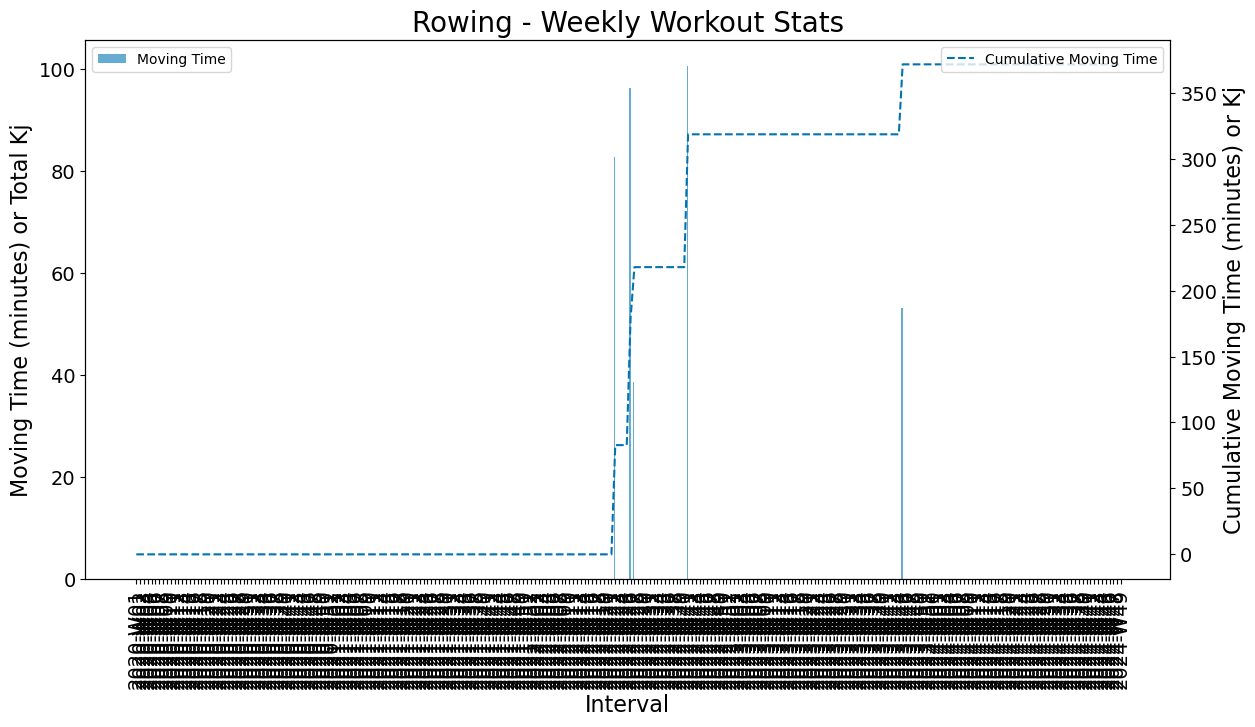

No Kilogoules


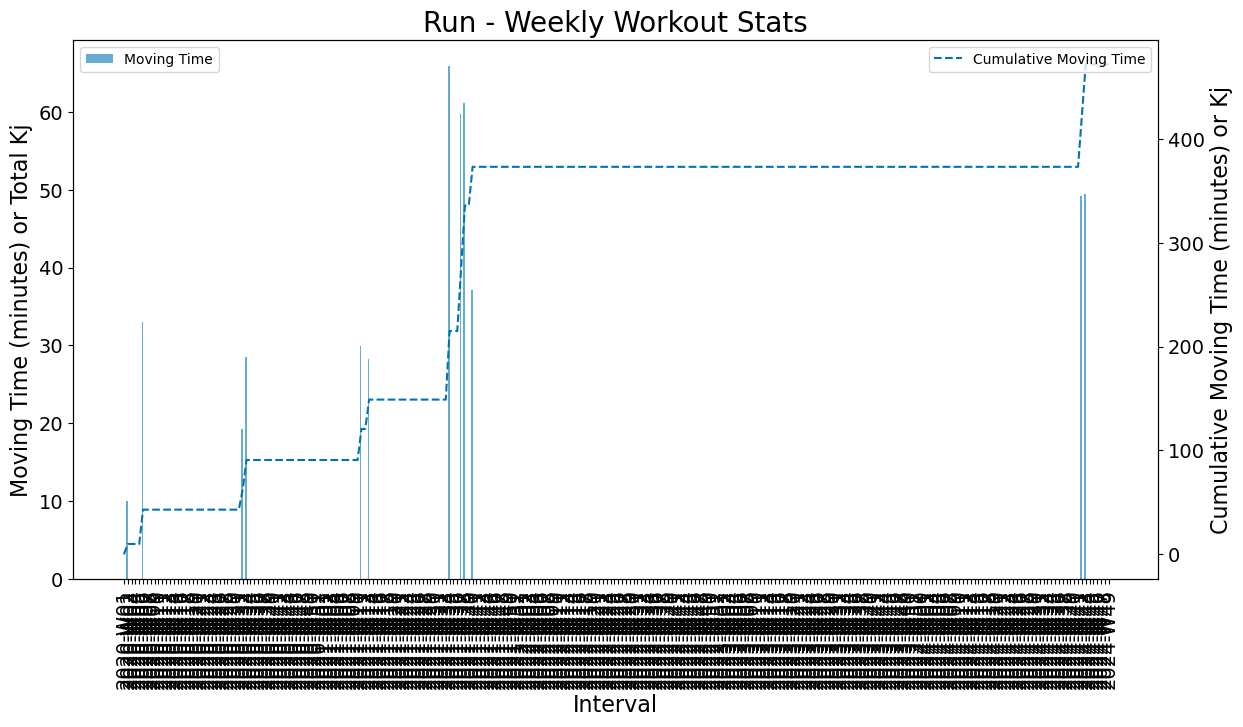

No Kilogoules


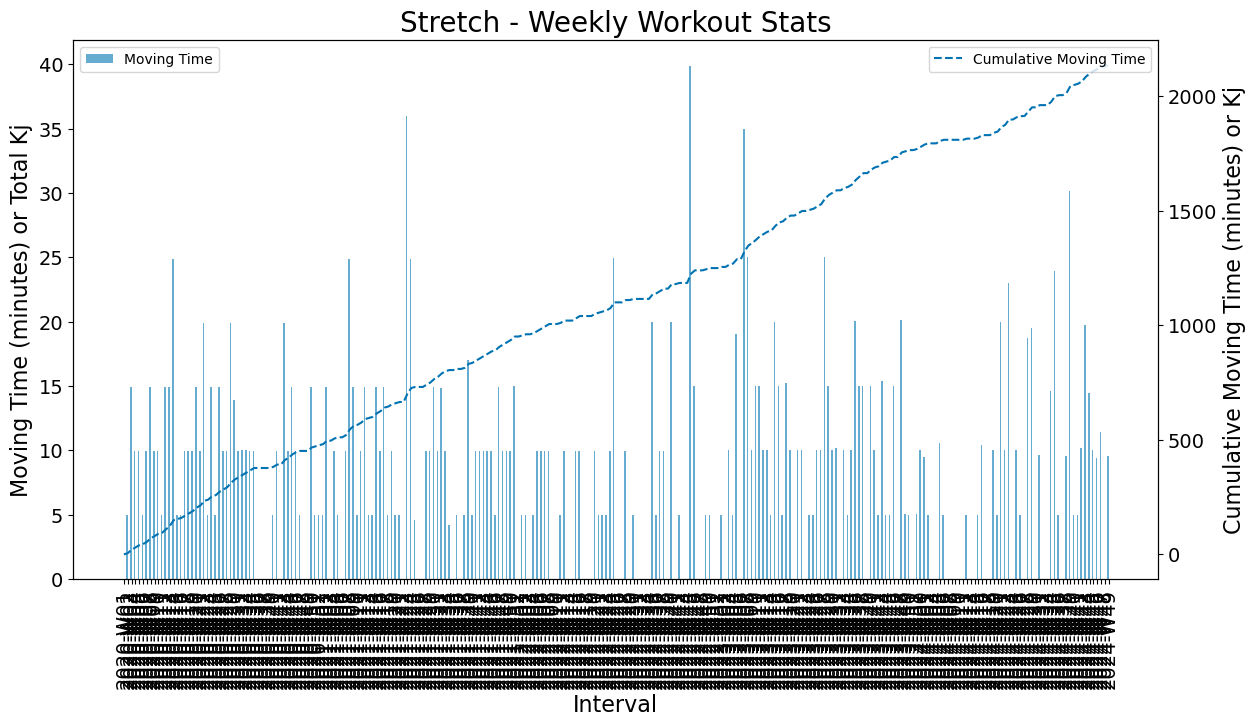

No Kilogoules


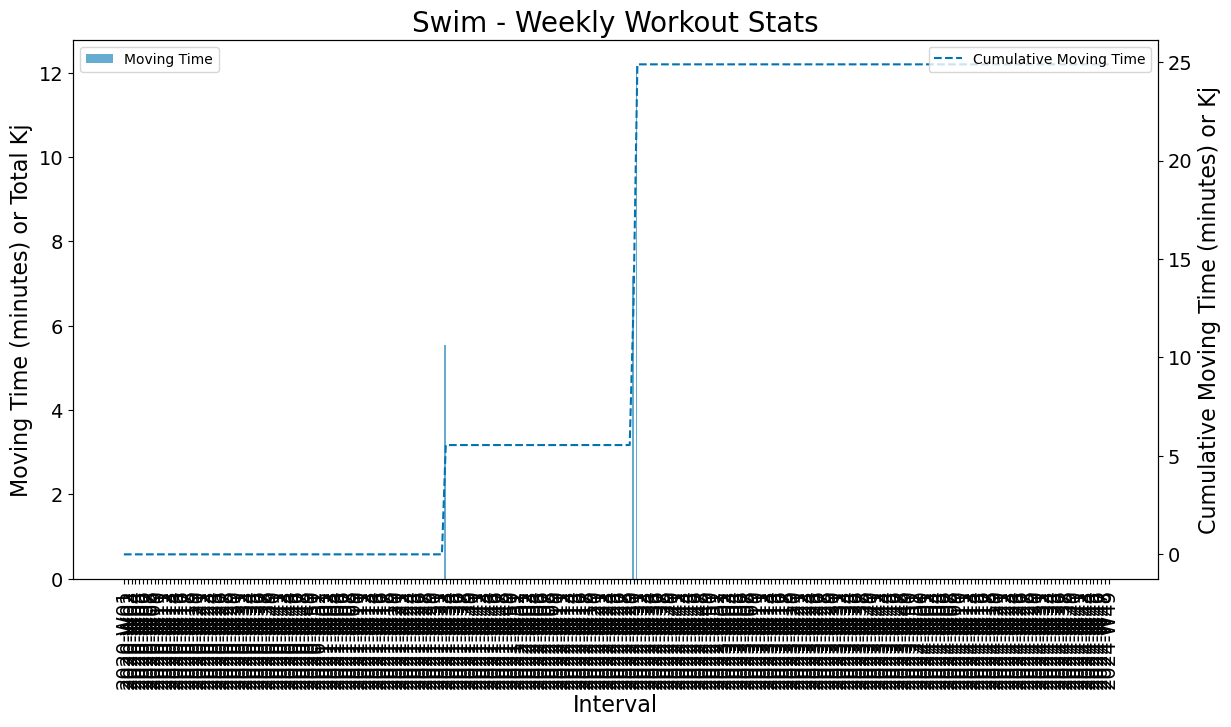

No Kilogoules


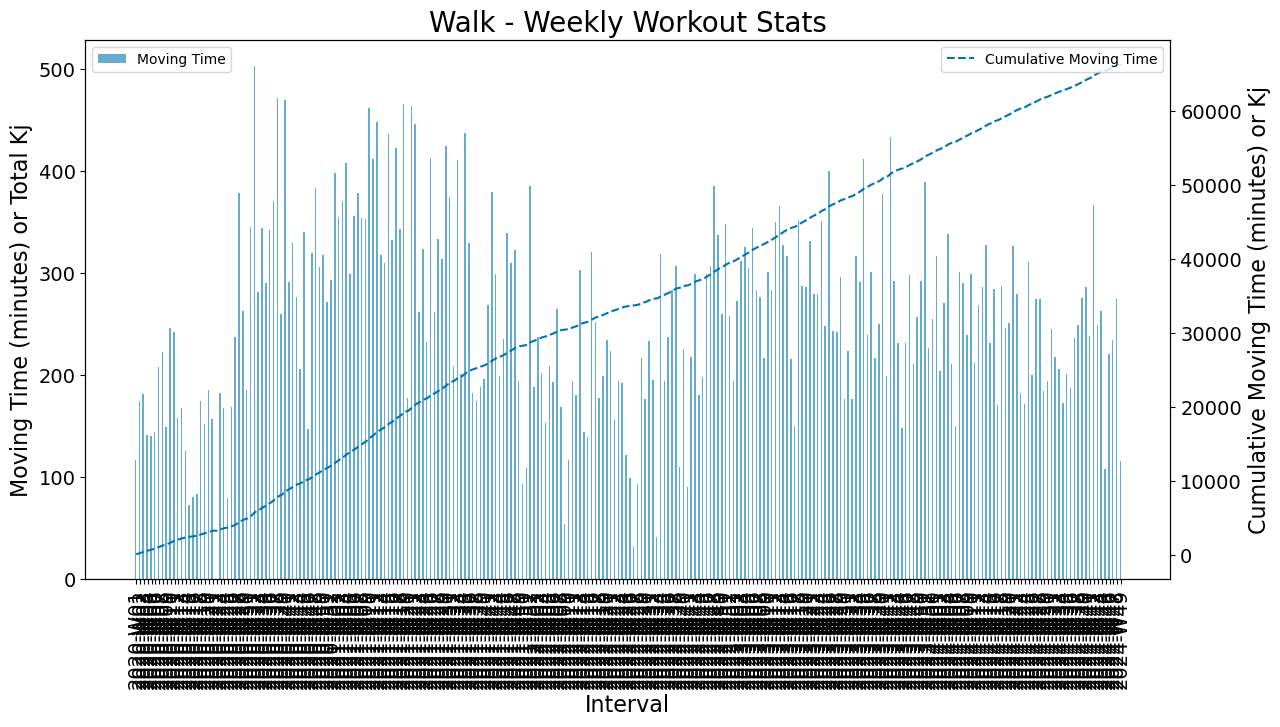

No Kilogoules


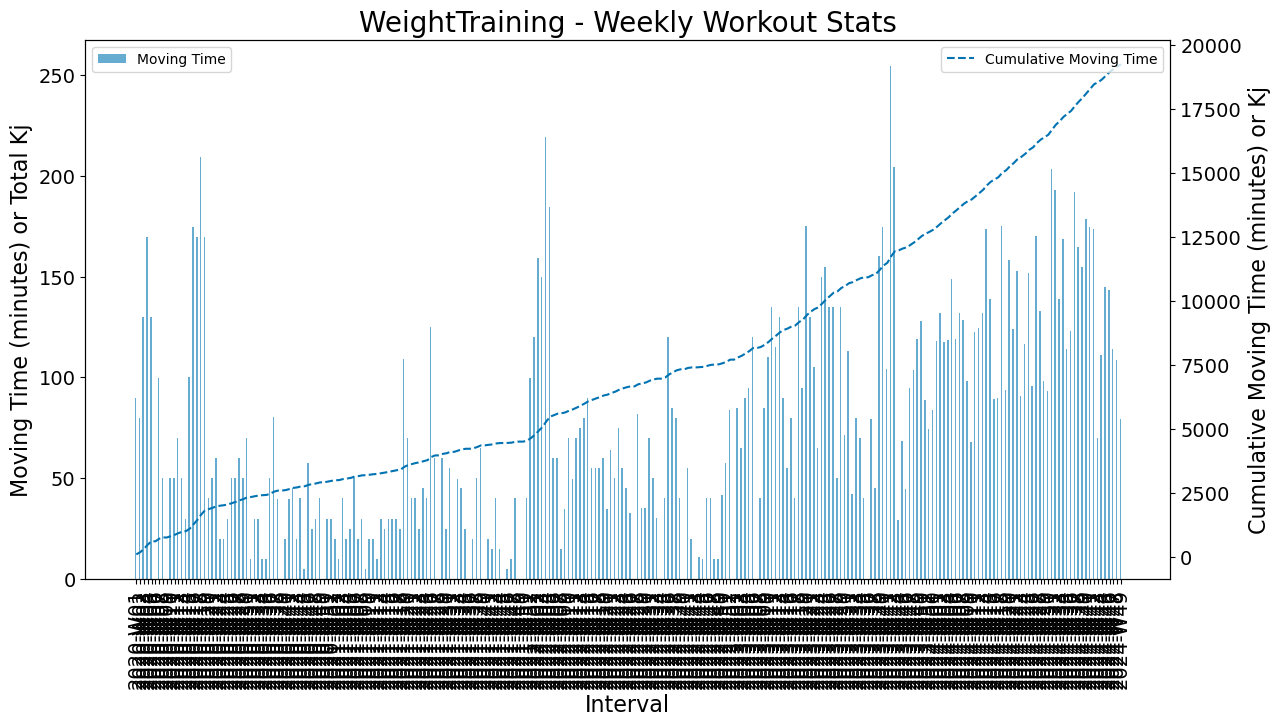

No Kilogoules


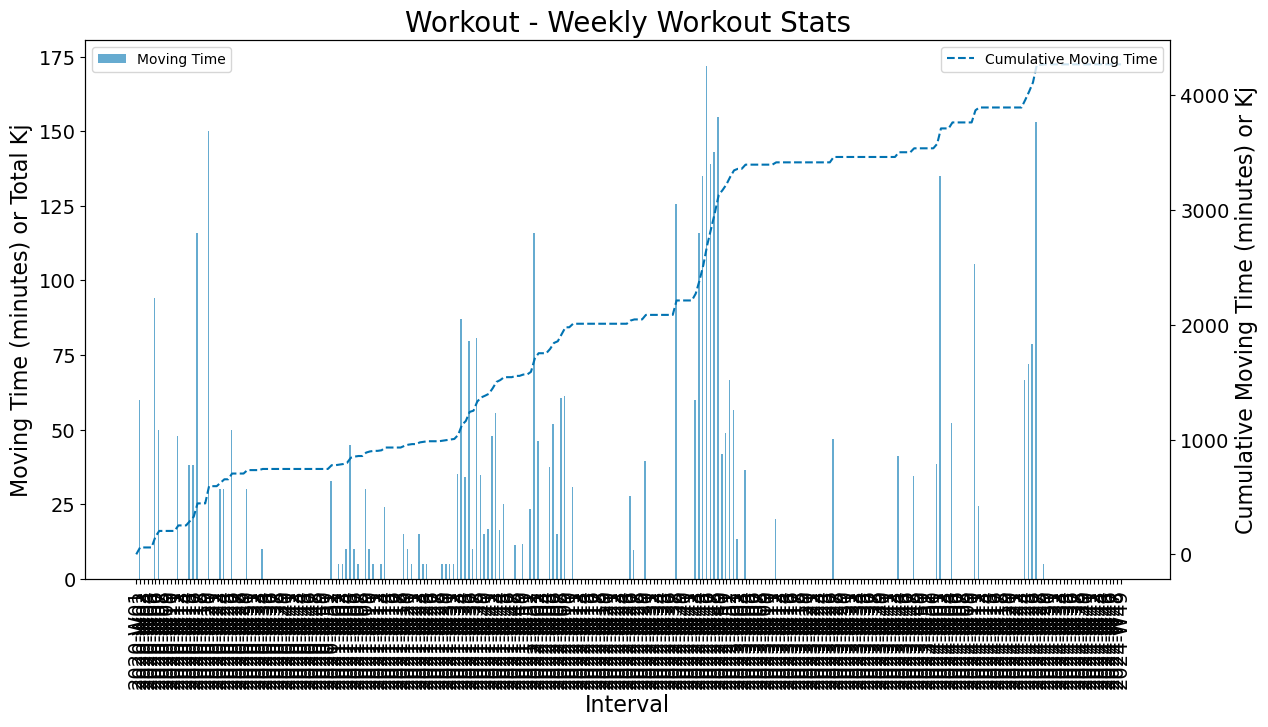

No Kilogoules


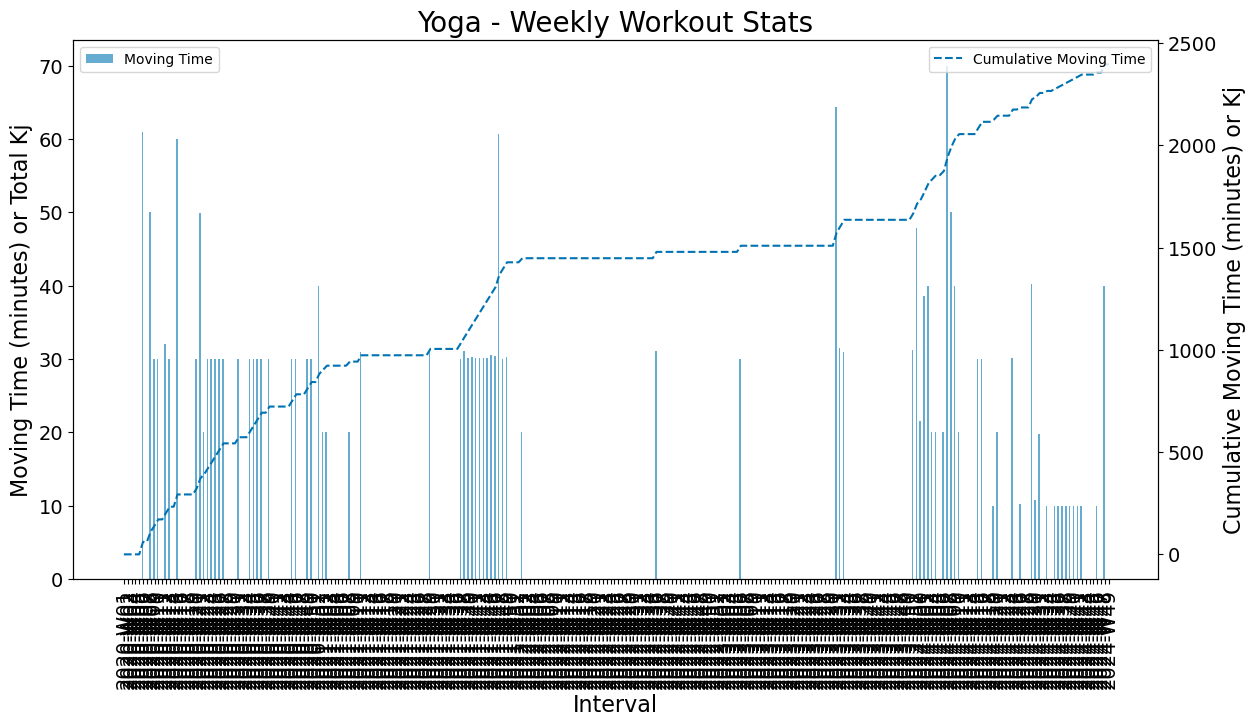

In [12]:
# Create combined bar chart and cumsum chart for each sport_type
# Create a common set of intervals
# Generate a complete range of weekly intervals
min_date = df_weekly['start_date'].min()
max_date = df_weekly['start_date'].max()
all_intervals = pd.date_range(start=min_date, end=max_date, freq='W-Mon').strftime('%Y-W%U')

# Create combined bar chart and cumsum chart for each sport_type
for sport in df_weekly['sport_type'].unique():
    df_sport = df_weekly[df_weekly['sport_type'] == sport]
    
    # Align intervals
    df_sport = df_sport.set_index('interval').reindex(all_intervals).reset_index().rename(columns={'index': 'interval'})
    df_sport['moving_time'] = df_sport['moving_time'].fillna(0)
    df_sport['kilojoules'] = df_sport['kilojoules'].fillna(0)
    df_sport['cumsum_moving_time'] = df_sport['cumsum_moving_time'].fillna(method='ffill').fillna(0)
    df_sport['cumsum_kilojoules'] = df_sport['cumsum_kilojoules'].fillna(method='ffill').fillna(0)
    
    fig, ax1 = plt.subplots(figsize=(14, 7))

    bar_width = 0.4
    intervals = range(len(all_intervals))

    # Bar chart for moving_time
    bars1=ax1.bar([i - bar_width/2 for i in intervals], df_sport['moving_time'], width=bar_width, alpha=0.6, label='Moving Time')
    ax1.set_xlabel('Interval')
    ax1.set_ylabel('Moving Time (minutes) or Total Kj')
    ax1.tick_params(axis='y')
    ax1.set_xticks(intervals)
    ax1.set_xticklabels(all_intervals, rotation=90)

    # Twin y-axis for cumulative sum of moving_time
    ax2 = ax1.twinx()
    line1, = ax2.plot(df_sport['interval'], df_sport['cumsum_moving_time'], linestyle='--', label='Cumulative Moving Time')
    ax2.set_ylabel('Cumulative Moving Time (minutes) or Kj')
    ax2.tick_params(axis='y')

    # Skip plotting kilojoules if the sum is 0
    if df_sport['kilojoules'].sum() == 0:
        print("No Kilogoules")
    else:
        # Bar chart for kilojoules
        bars2=ax1.bar([i + bar_width/2 for i in intervals], df_sport['kilojoules'], width=bar_width, alpha=0.6, label='Kilojoules')

        # Twin y-axis for cumulative sum of kilojoules
        line2,=ax2.plot(df_sport['interval'], df_sport['cumsum_kilojoules'], linestyle='--', label='Cumulative Kilojoules')

    # Add legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Set title
    plt.title(f'{sport} - Weekly Workout Stats')

    plt.show()

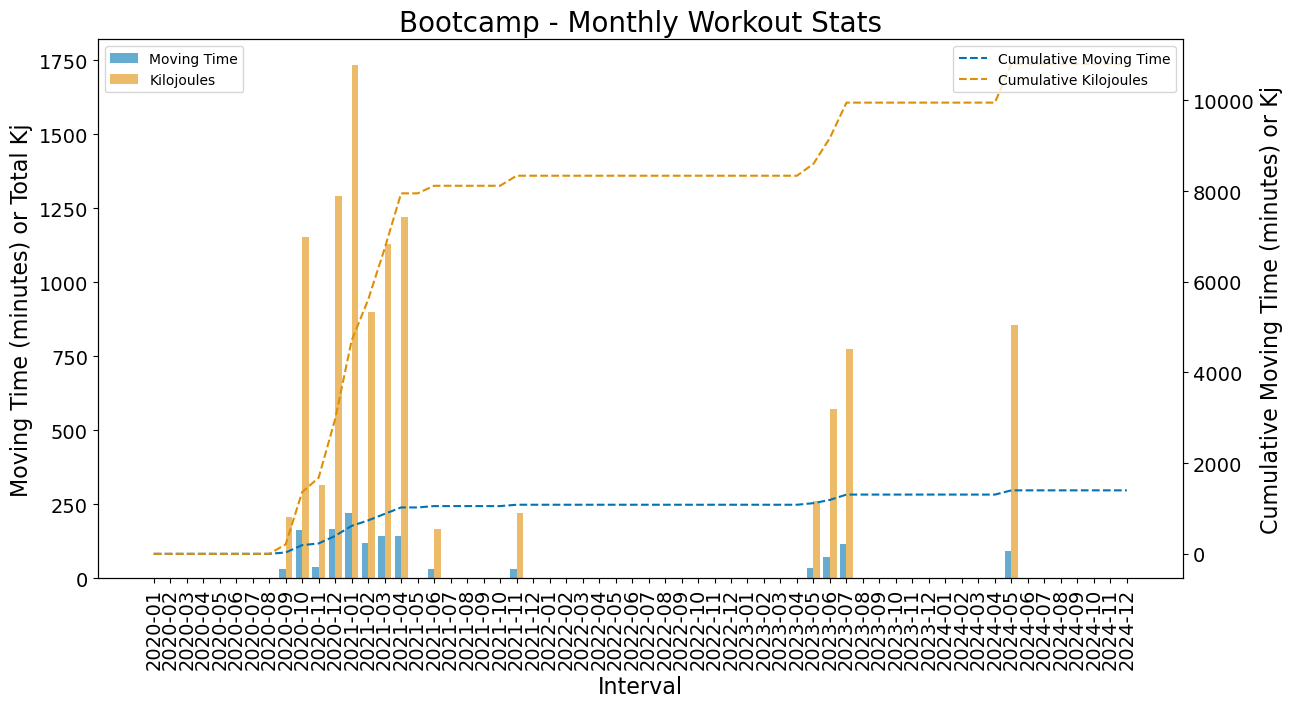

No Kilojoules


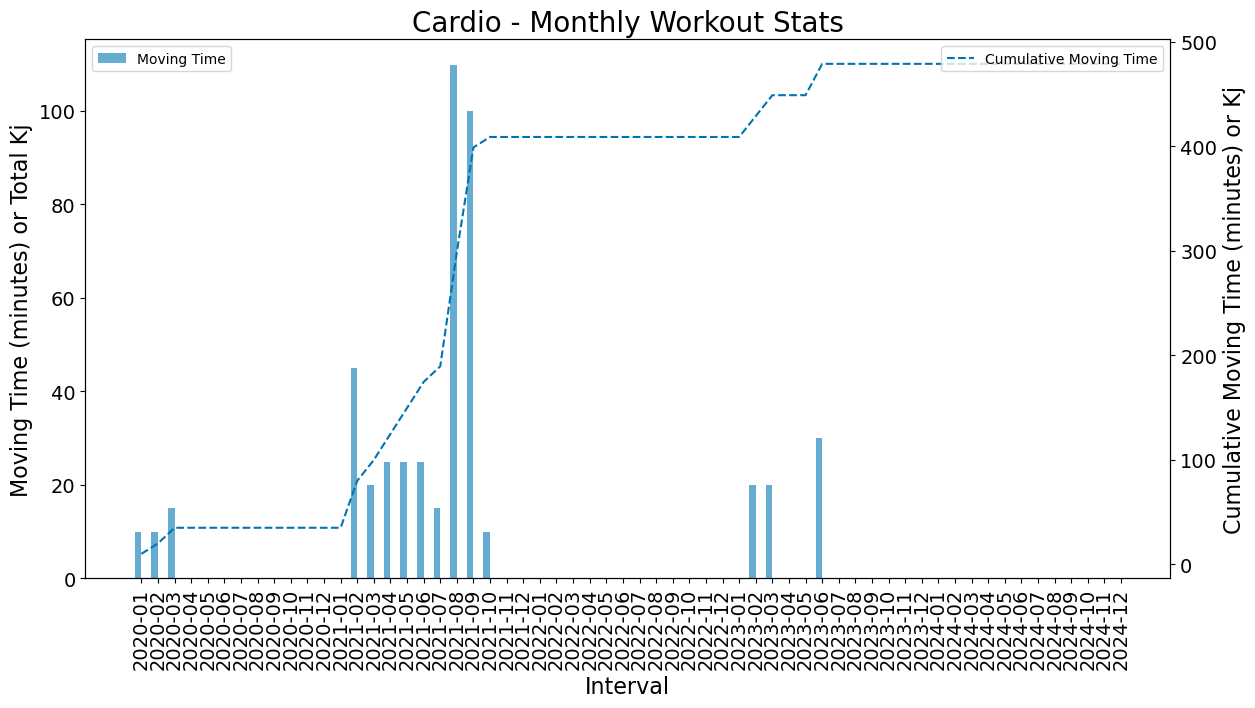

No Kilojoules


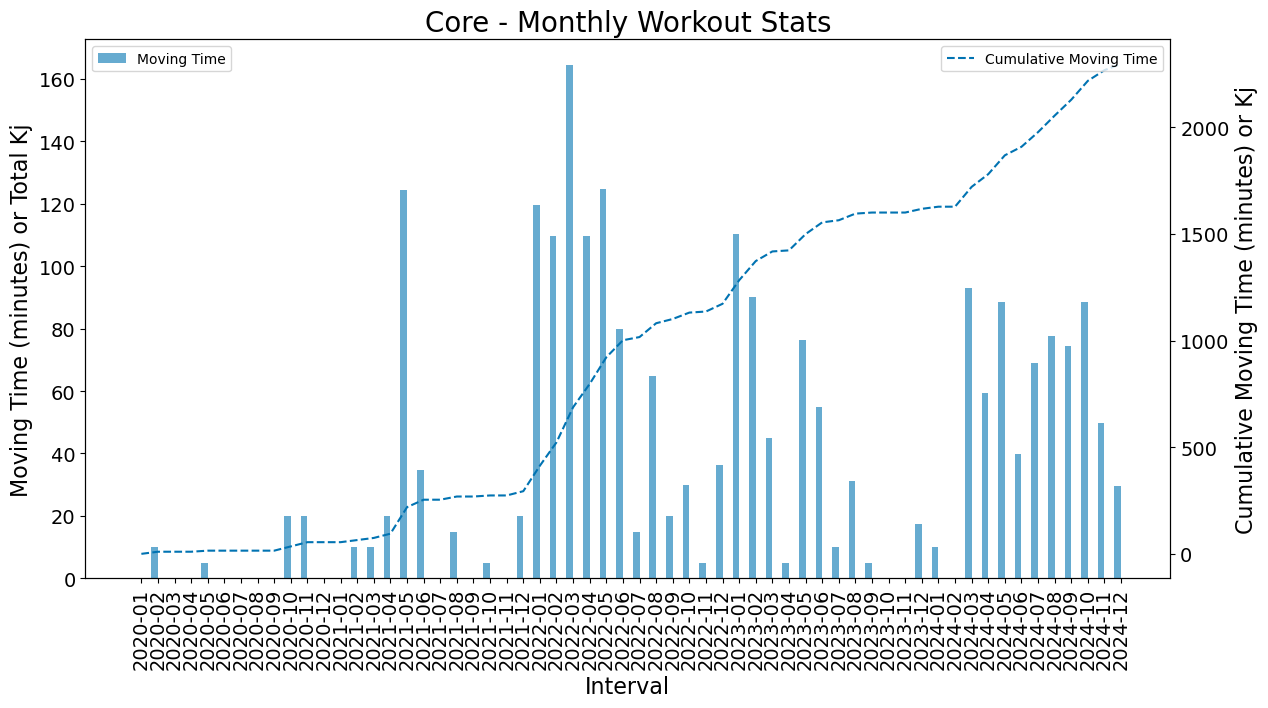

No Kilojoules


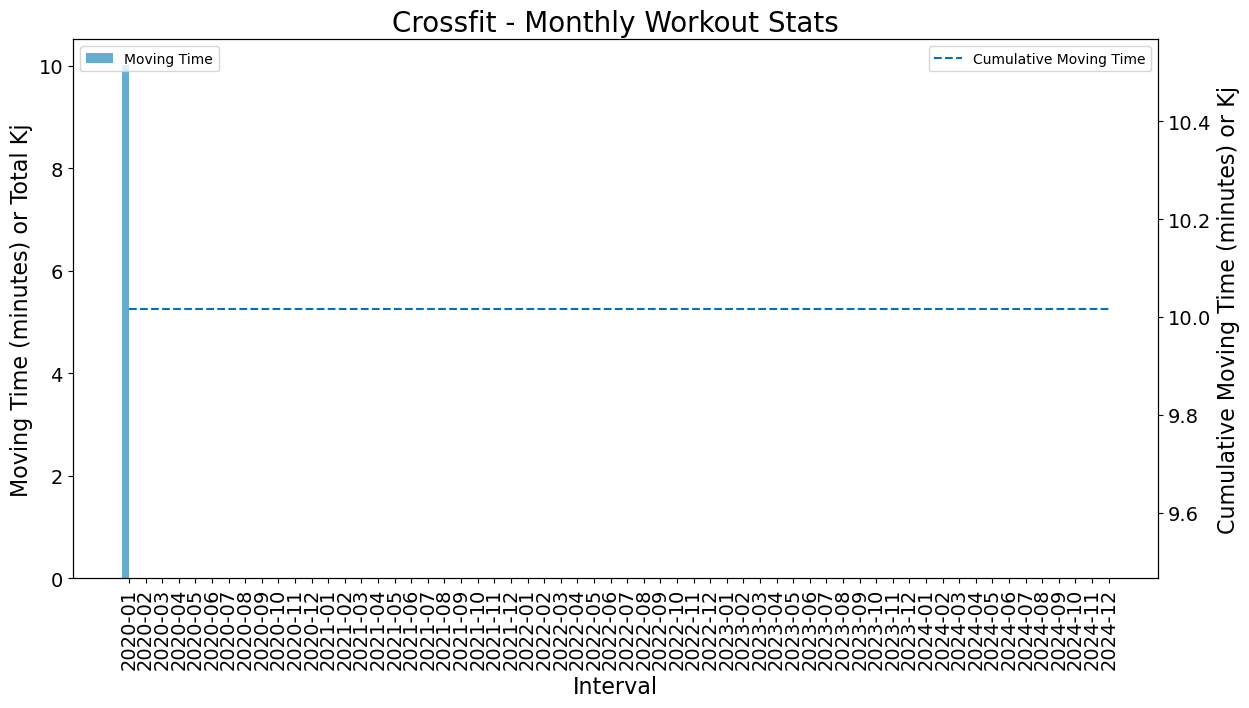

No Kilojoules


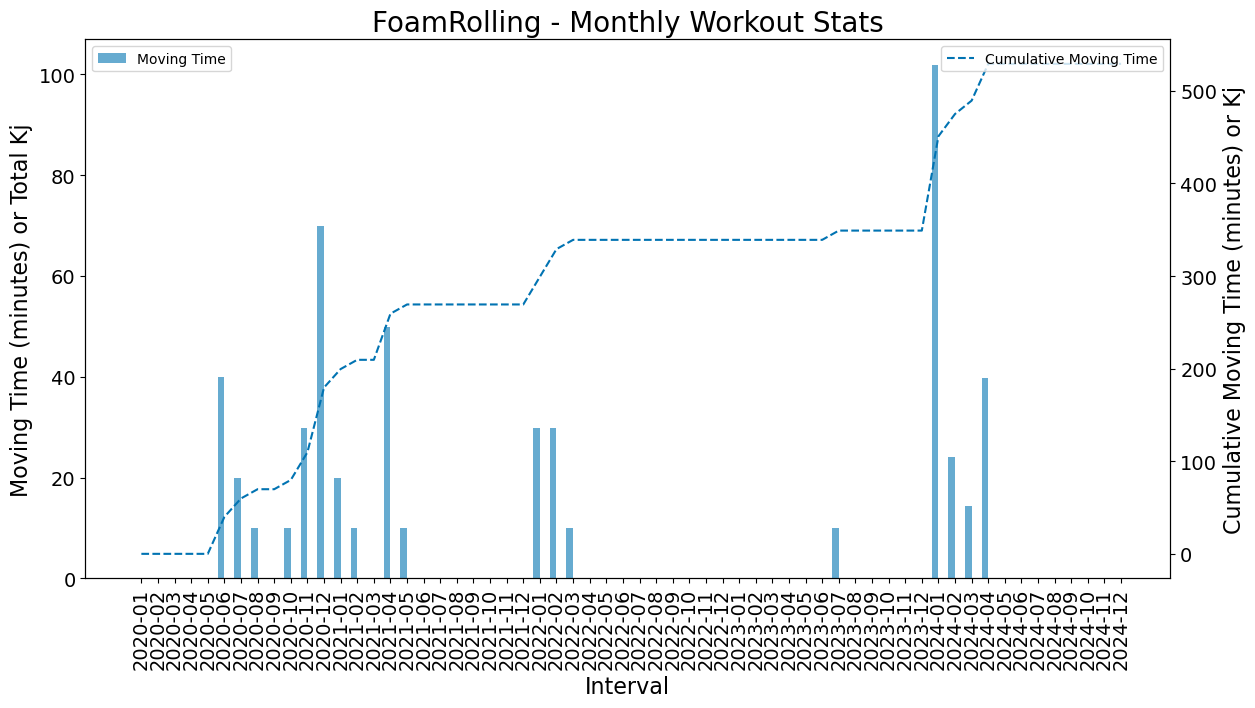

No Kilojoules


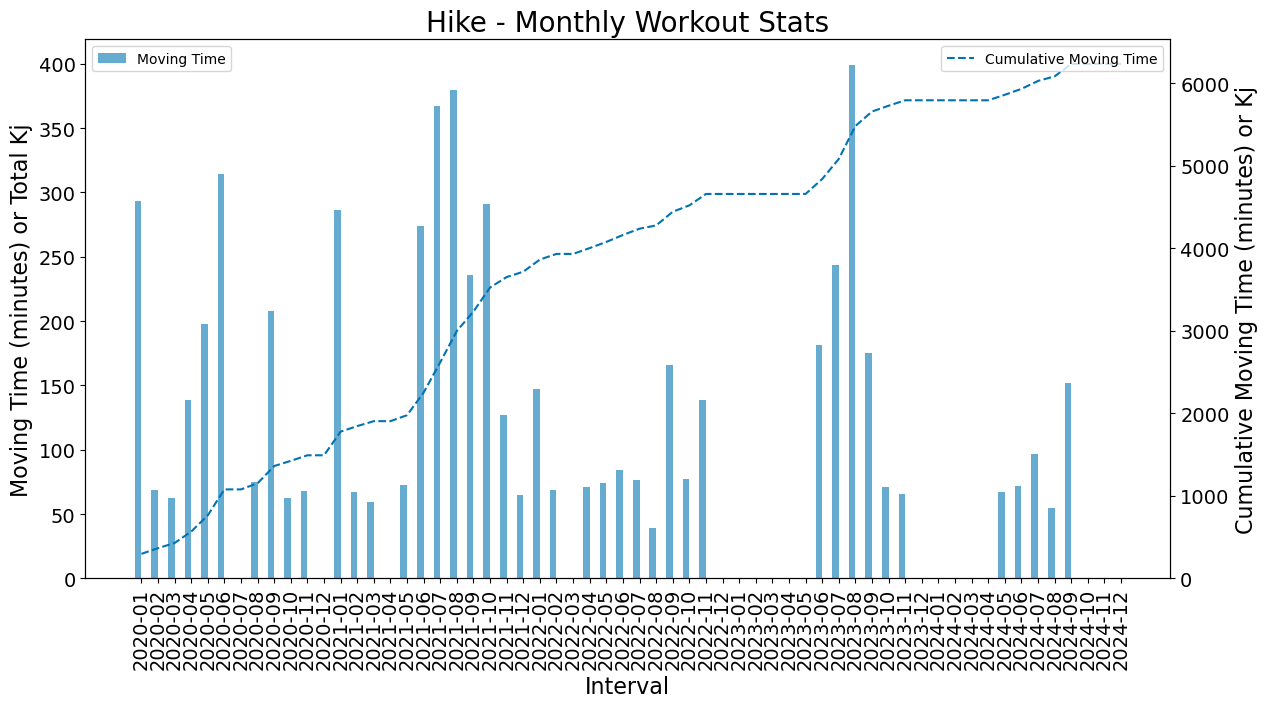

No Kilojoules


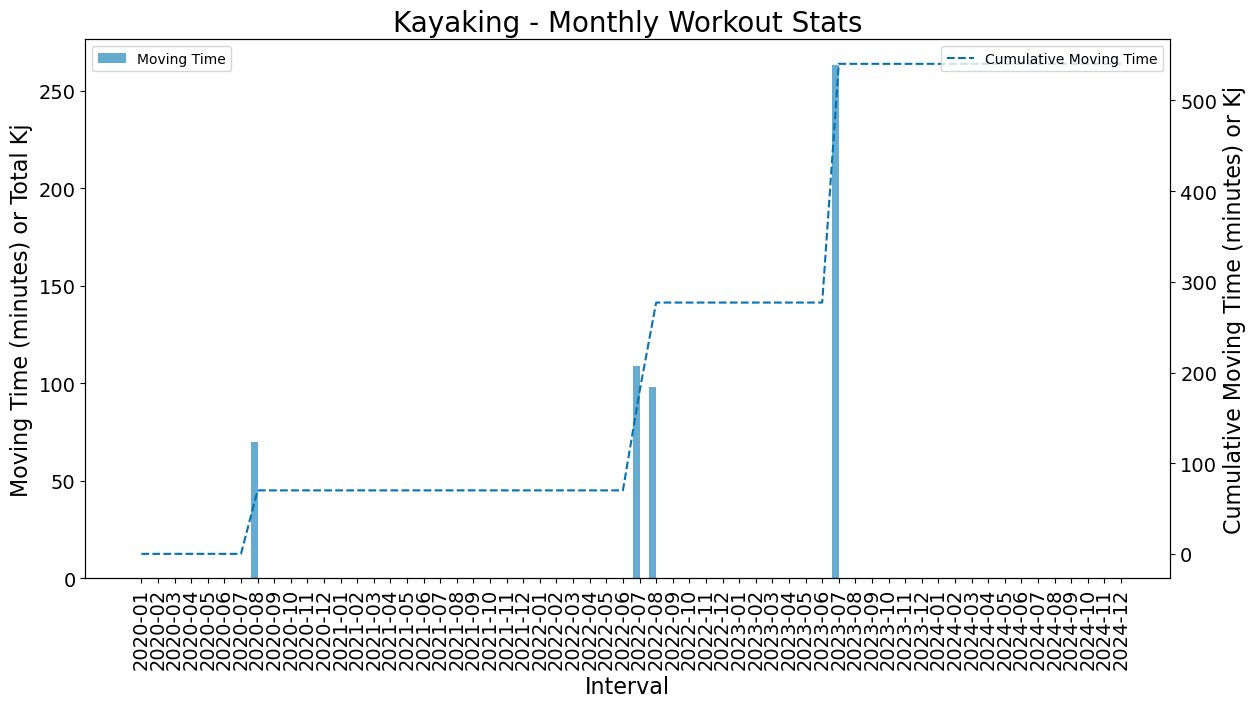

No Kilojoules


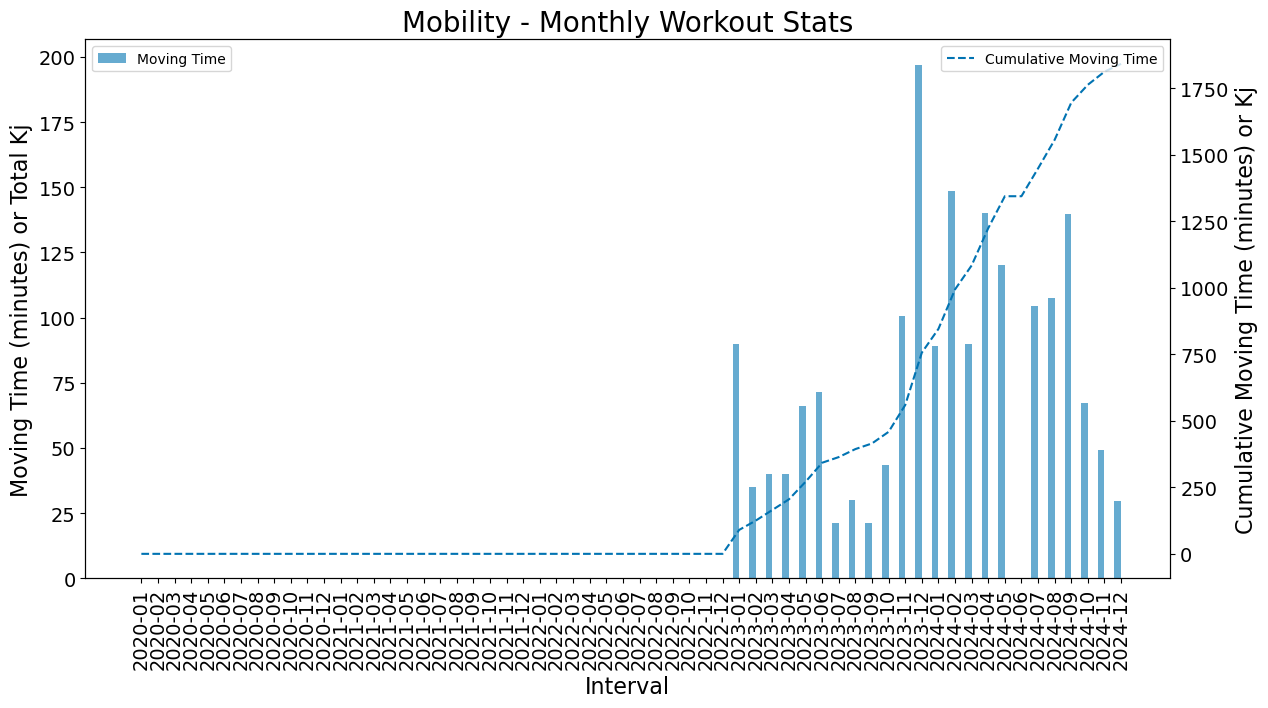

No Kilojoules


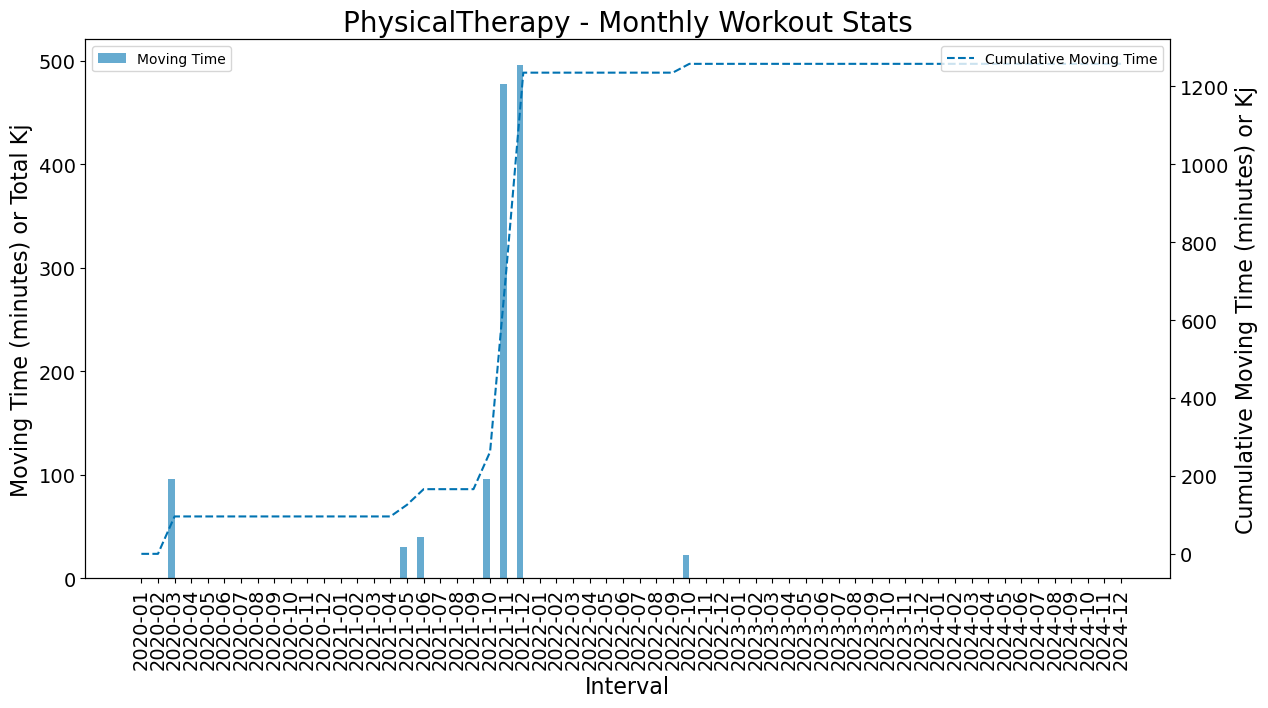

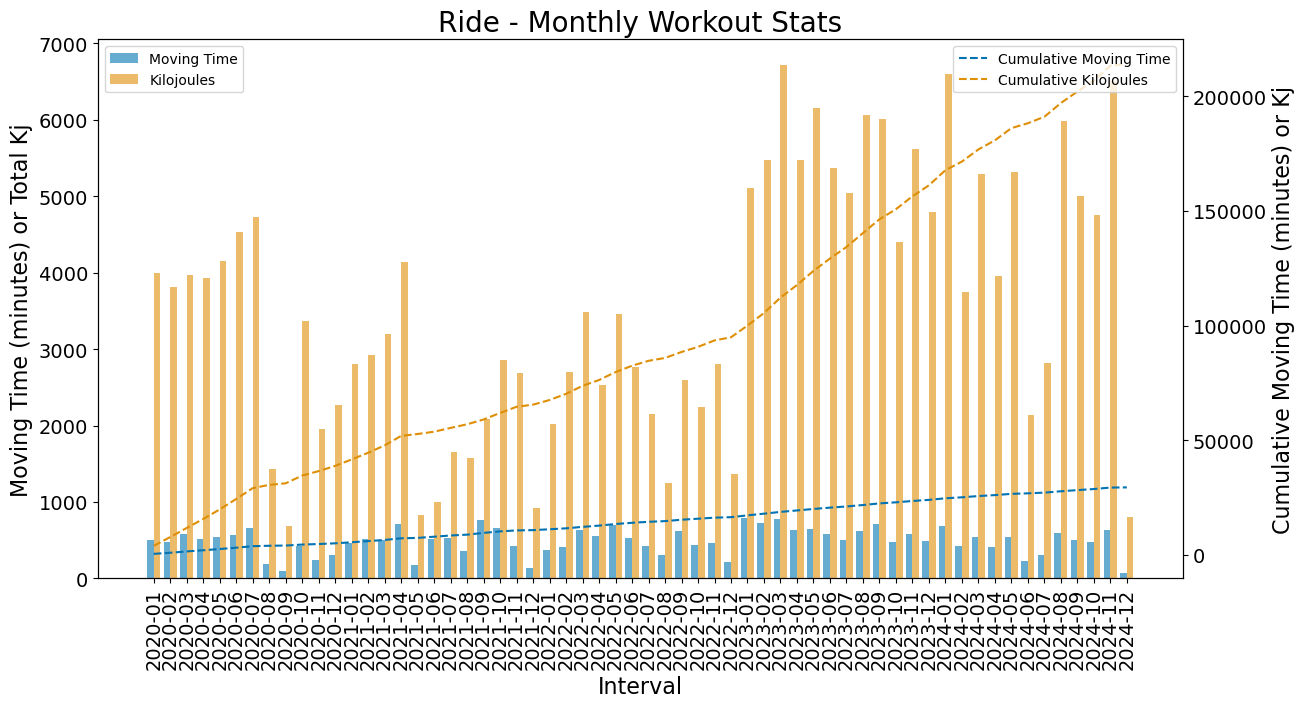

No Kilojoules


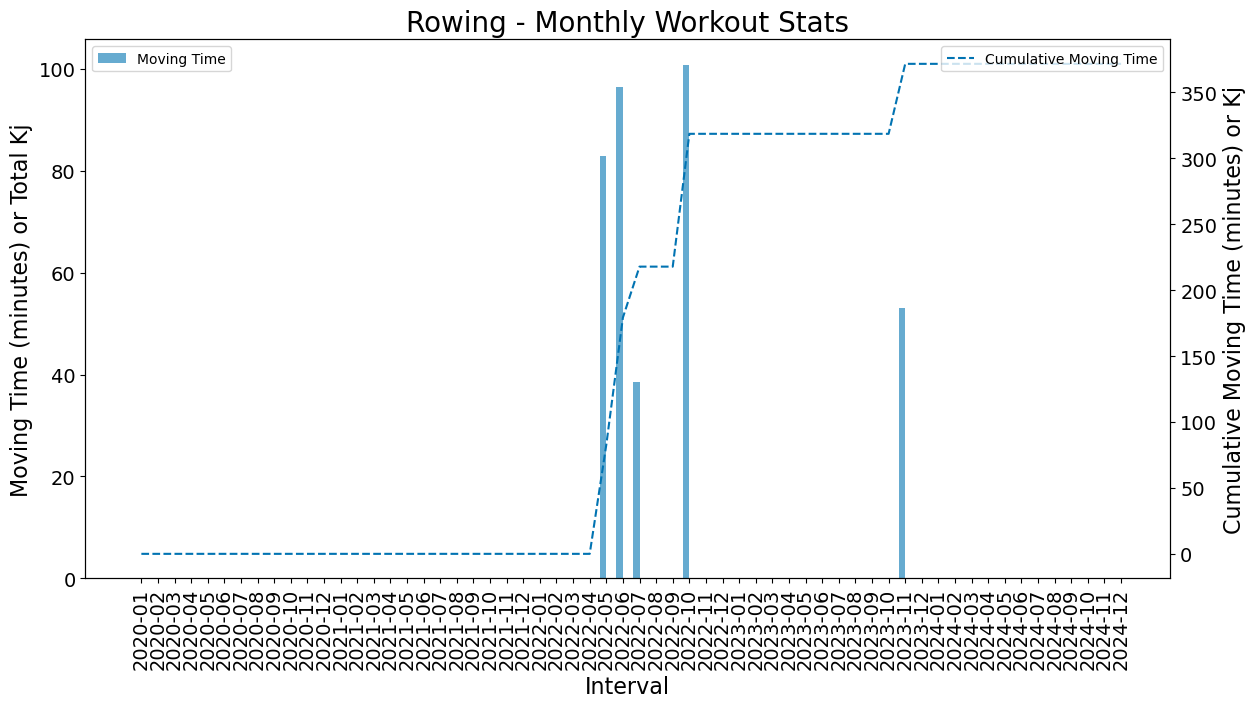

No Kilojoules


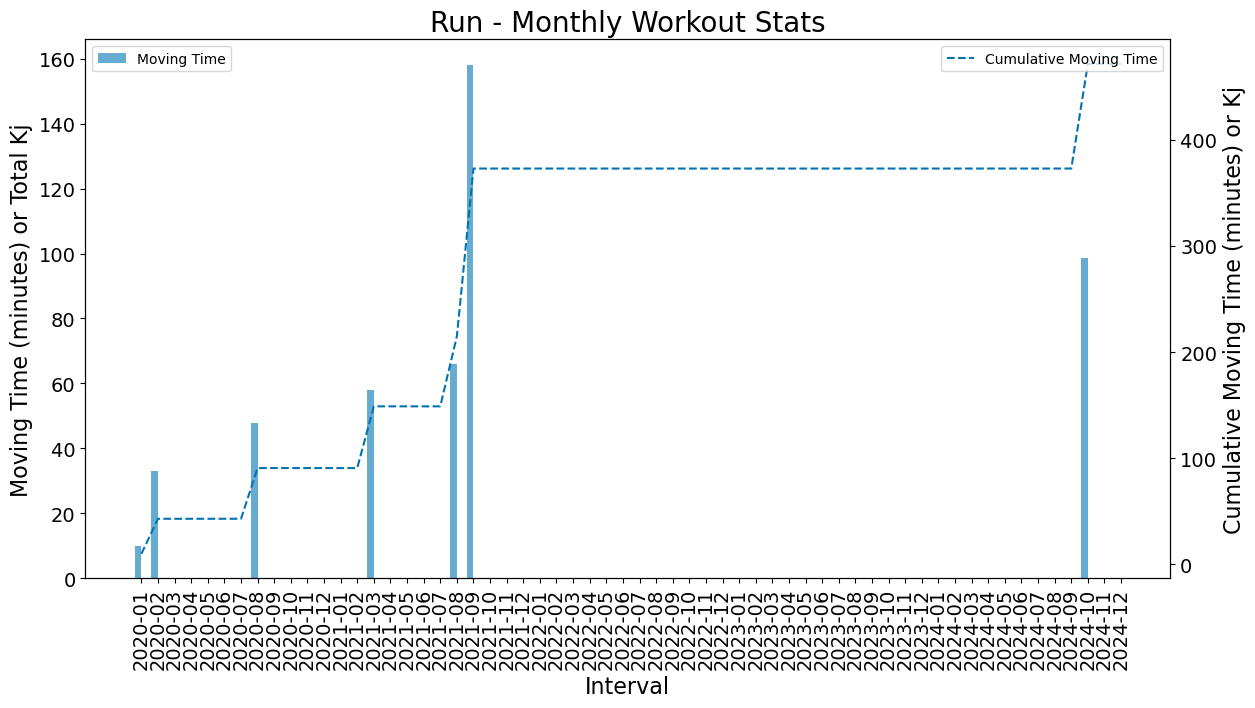

No Kilojoules


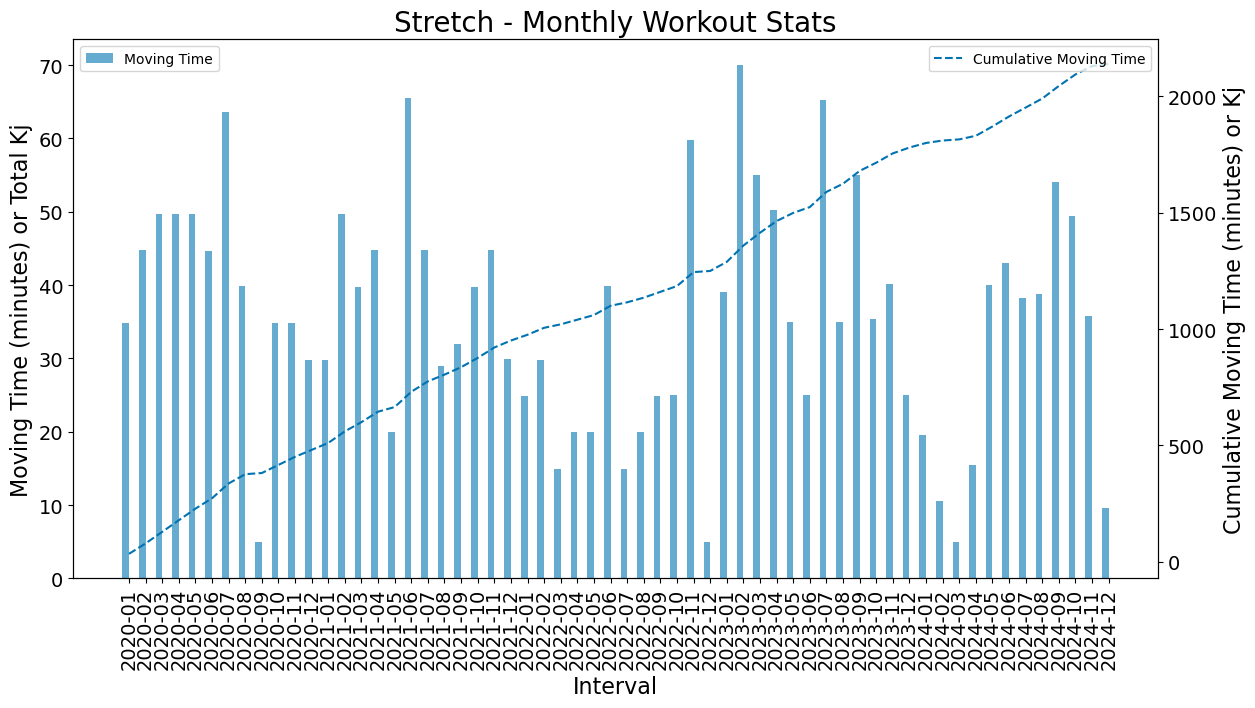

No Kilojoules


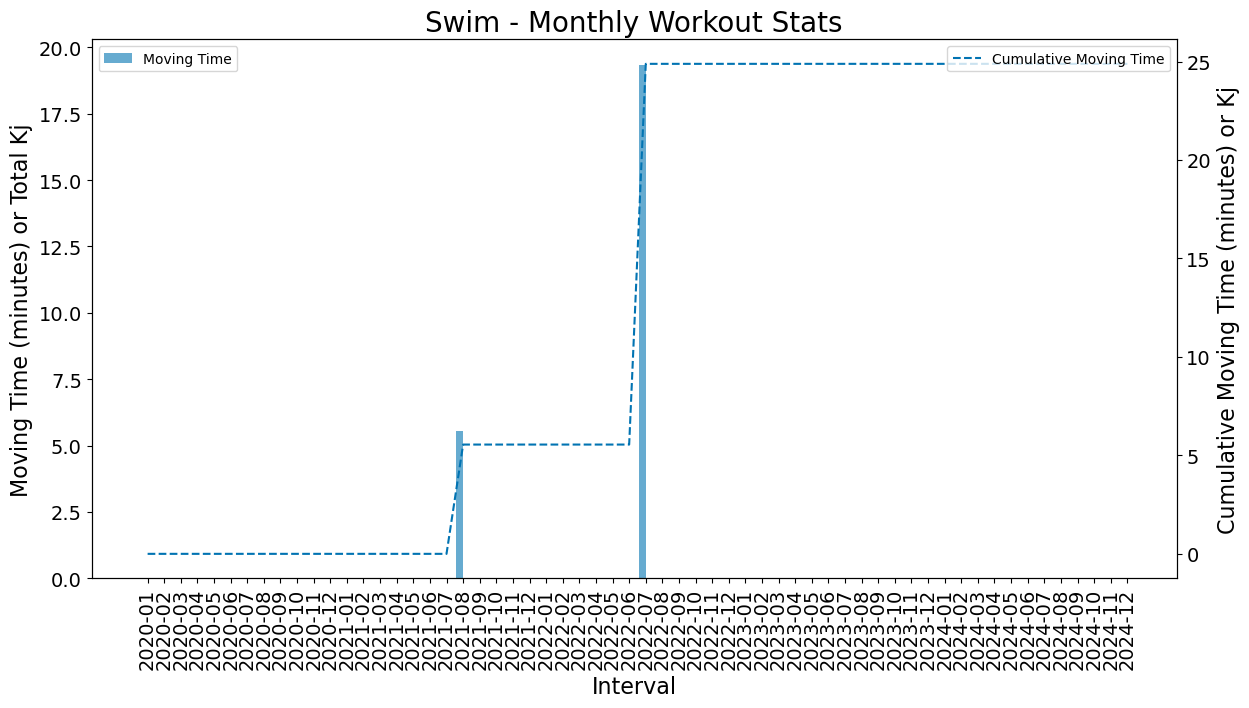

No Kilojoules


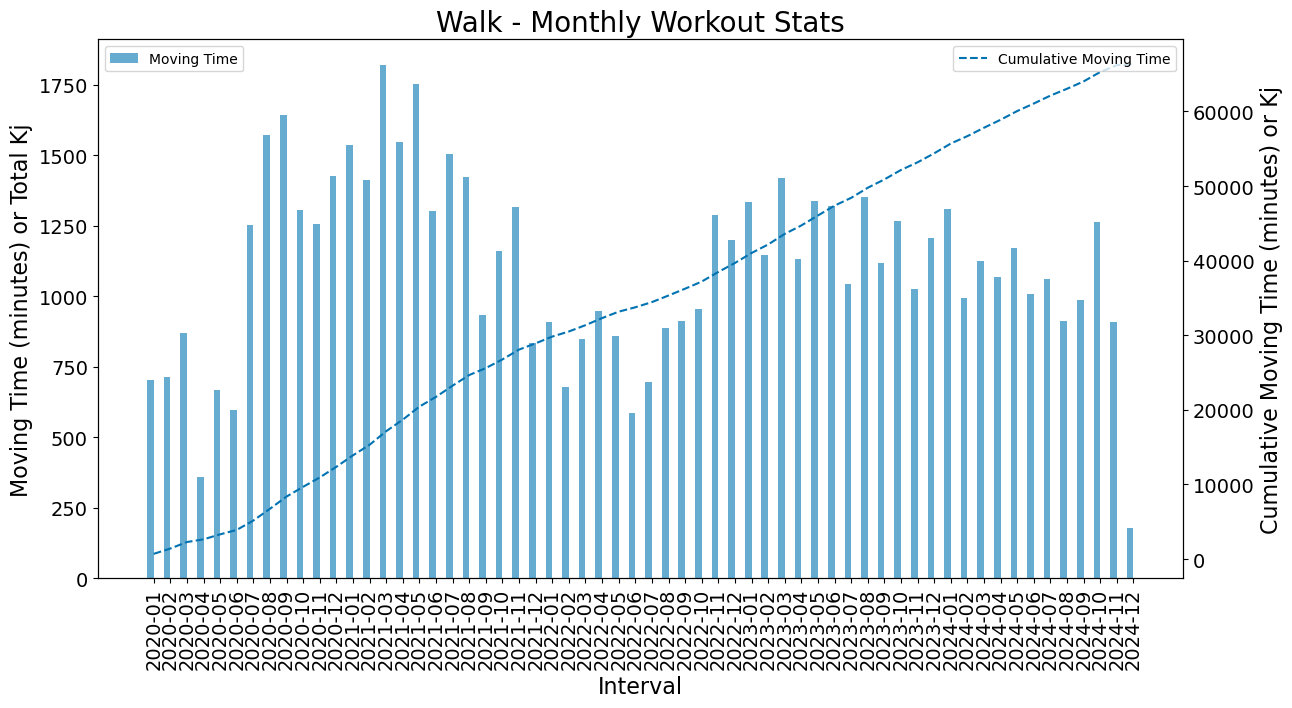

No Kilojoules


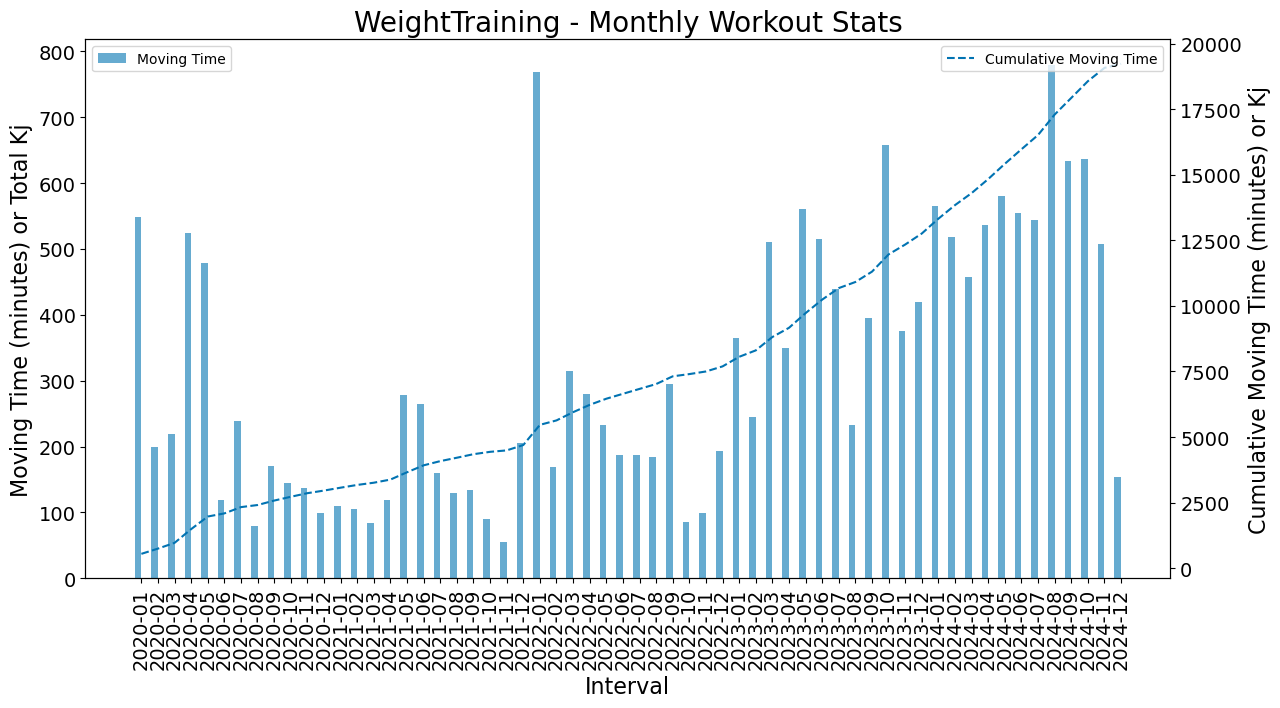

No Kilojoules


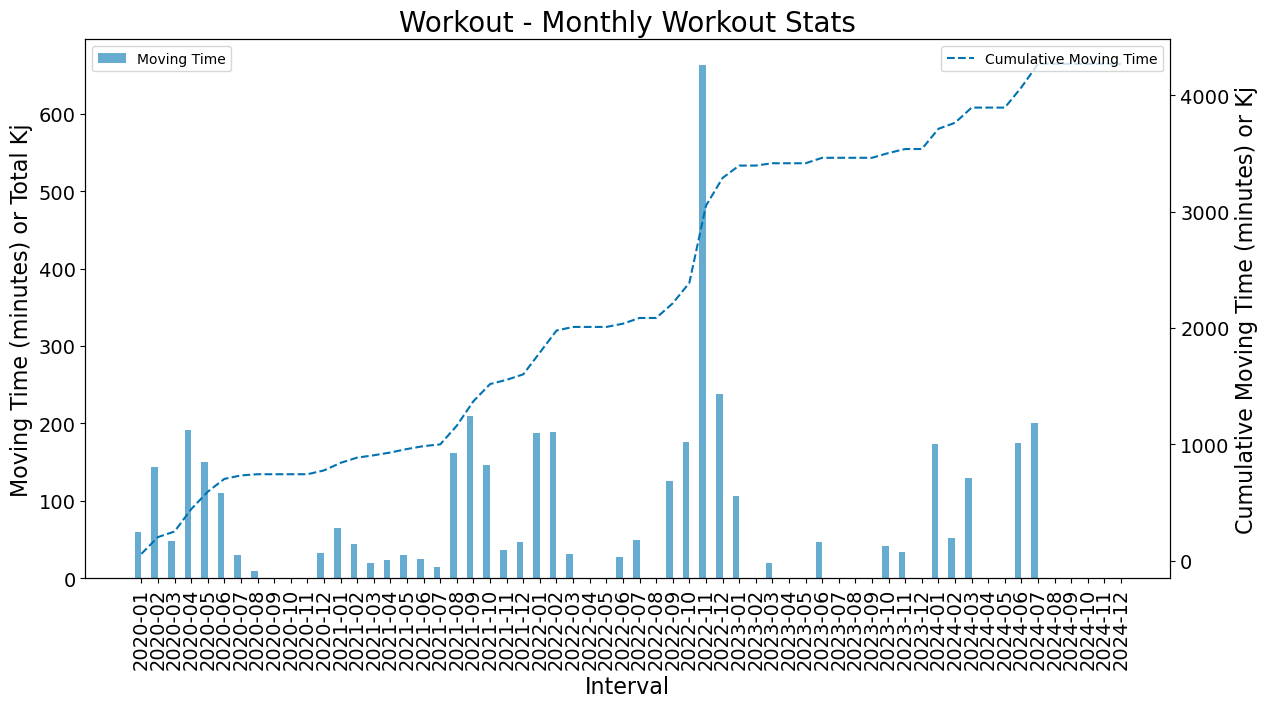

No Kilojoules


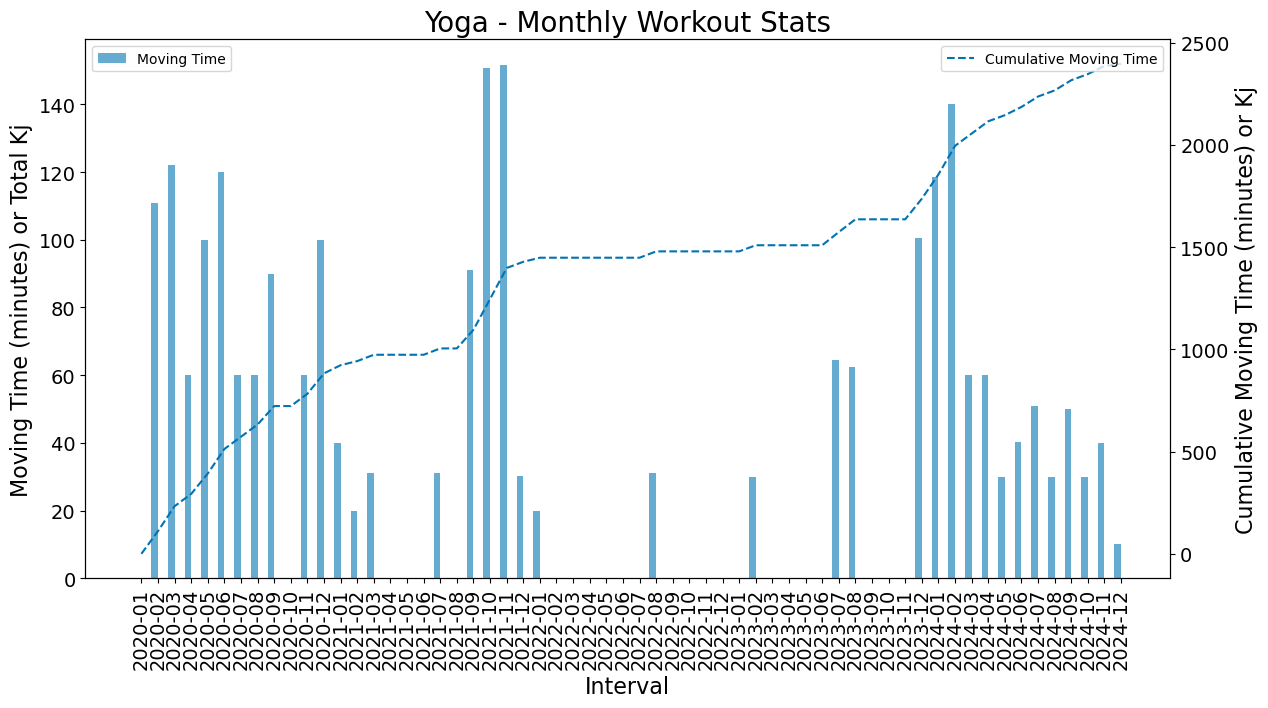

In [13]:
# Create combined bar chart and cumsum chart for each sport_type
# Create a common set of intervals
# Generate a complete range of weekly intervals
min_date = df_monthly['start_date'].min()
max_date = df_monthly['start_date'].max()
all_intervals = pd.date_range(start=min_date, end=max_date, freq='M').strftime('%Y-%m')

# Create combined bar chart and cumsum chart for each sport_type
for sport in df_monthly['sport_type'].unique():
    df_sport = df_monthly[df_monthly['sport_type'] == sport]
    
    # Align intervals
    df_sport = df_sport.set_index('interval').reindex(all_intervals).reset_index().rename(columns={'index': 'interval'})
    df_sport['moving_time'] = df_sport['moving_time'].fillna(0)
    df_sport['kilojoules'] = df_sport['kilojoules'].fillna(0)
    df_sport['cumsum_moving_time'] = df_sport['cumsum_moving_time'].fillna(method='ffill').fillna(0)
    df_sport['cumsum_kilojoules'] = df_sport['cumsum_kilojoules'].fillna(method='ffill').fillna(0)
    
    fig, ax1 = plt.subplots(figsize=(14, 7))

    bar_width = 0.4
    intervals = range(len(all_intervals))

    # Bar chart for moving_time
    ax1.bar([i - bar_width/2 for i in intervals], df_sport['moving_time'], width=bar_width, alpha=0.6, label='Moving Time')
    ax1.set_xlabel('Interval')
    ax1.set_ylabel('Moving Time (minutes) or Total Kj')
    ax1.tick_params(axis='y')
    ax1.set_xticks(intervals)
    ax1.set_xticklabels(all_intervals, rotation=90)

    # Twin y-axis for cumulative sum of moving_time
    ax2 = ax1.twinx()
    ax2.plot(df_sport['interval'], df_sport['cumsum_moving_time'], linestyle='--', label='Cumulative Moving Time')
    ax2.set_ylabel('Cumulative Moving Time (minutes) or Kj')
    ax2.tick_params(axis='y')

    # Skip plotting kilojoules if the sum is 0
    if df_sport['kilojoules'].sum() == 0:
        print("No Kilojoules")
    else:
        # Bar chart for kilojoules
        ax1.bar([i + bar_width/2 for i in intervals], df_sport['kilojoules'], width=bar_width, alpha=0.6, label='Kilojoules')

        # Twin y-axis for cumulative sum of kilojoules
        ax2.plot(df_sport['interval'], df_sport['cumsum_kilojoules'], linestyle='--', label='Cumulative Kilojoules')

    # Add legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Set title
    plt.title(f'{sport} - Monthly Workout Stats')

    plt.show()

In [14]:
sports_to_remove=['Bootcamp', 'Cardio', 'Crossfit', 'FoamRolling', 'Kayaking', 'Rowing', 'Run', 'Stretch', 'Swim', 'Workout', 'Yoga']
df_monthly_sub = df_monthly[~df_monthly['sport_type'].isin(sports_to_remove)]

In [15]:
show(df_monthly_sub)

No Kilojoules


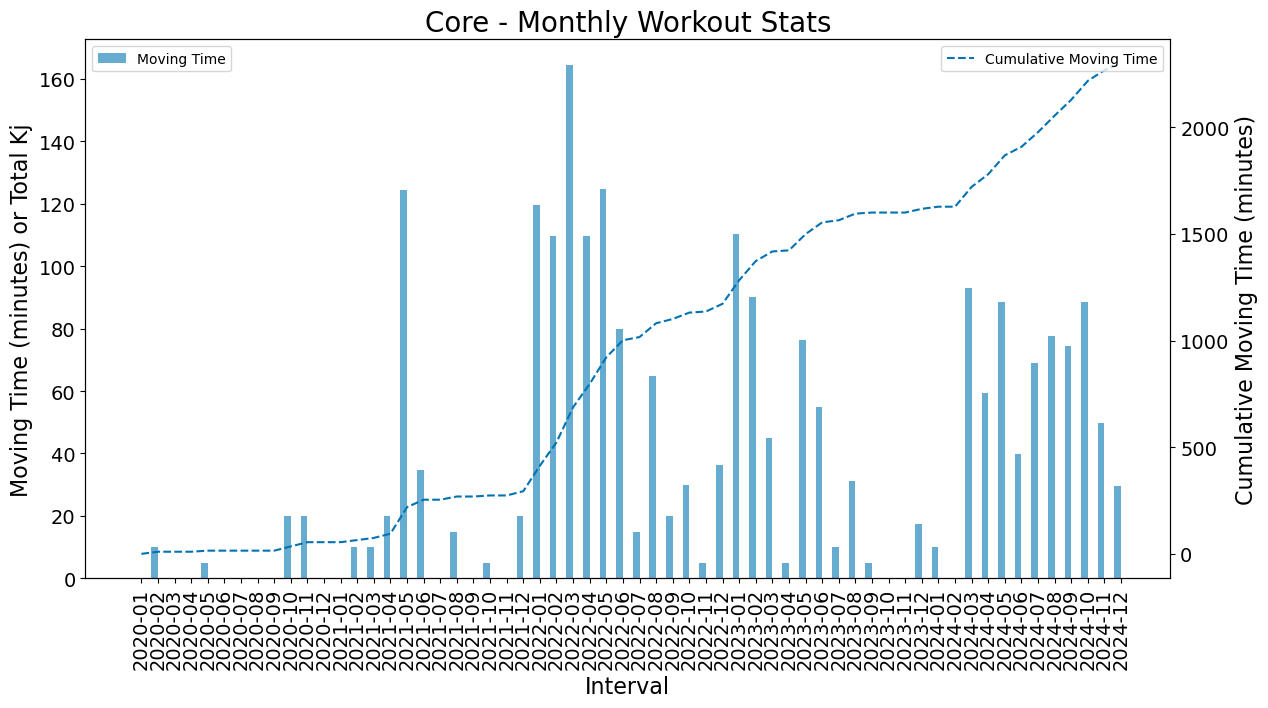

No Kilojoules


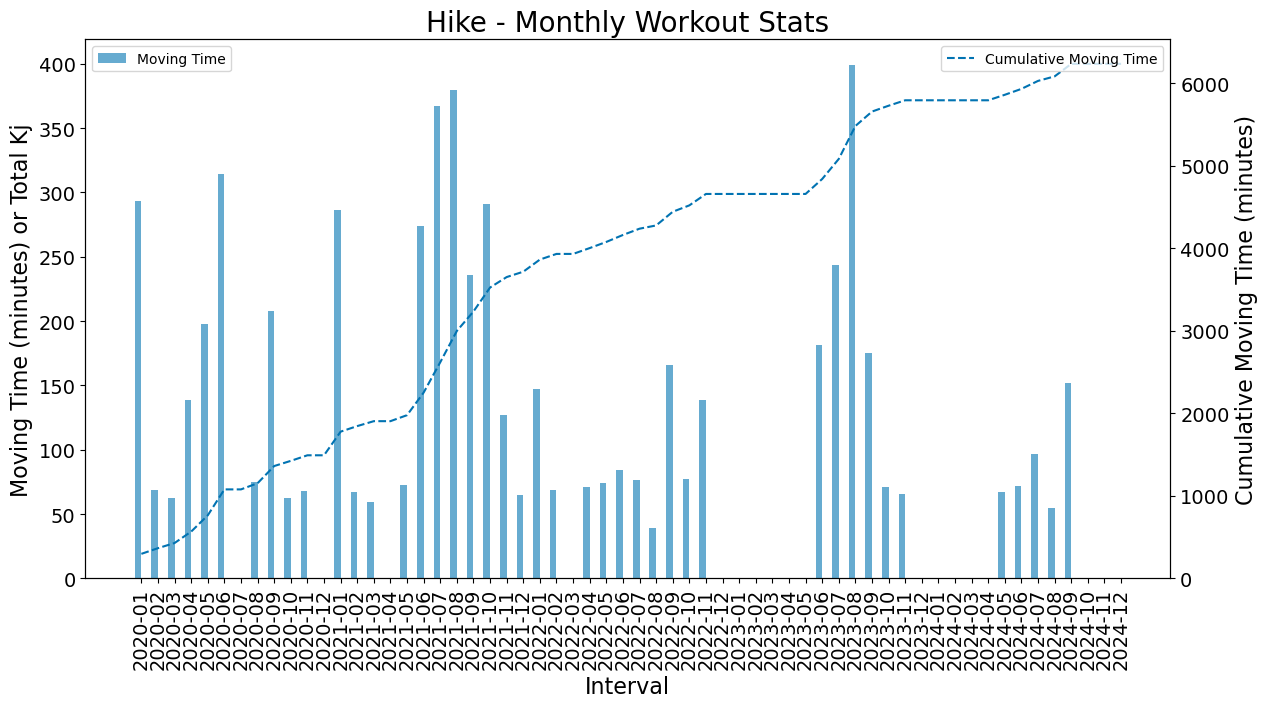

No Kilojoules


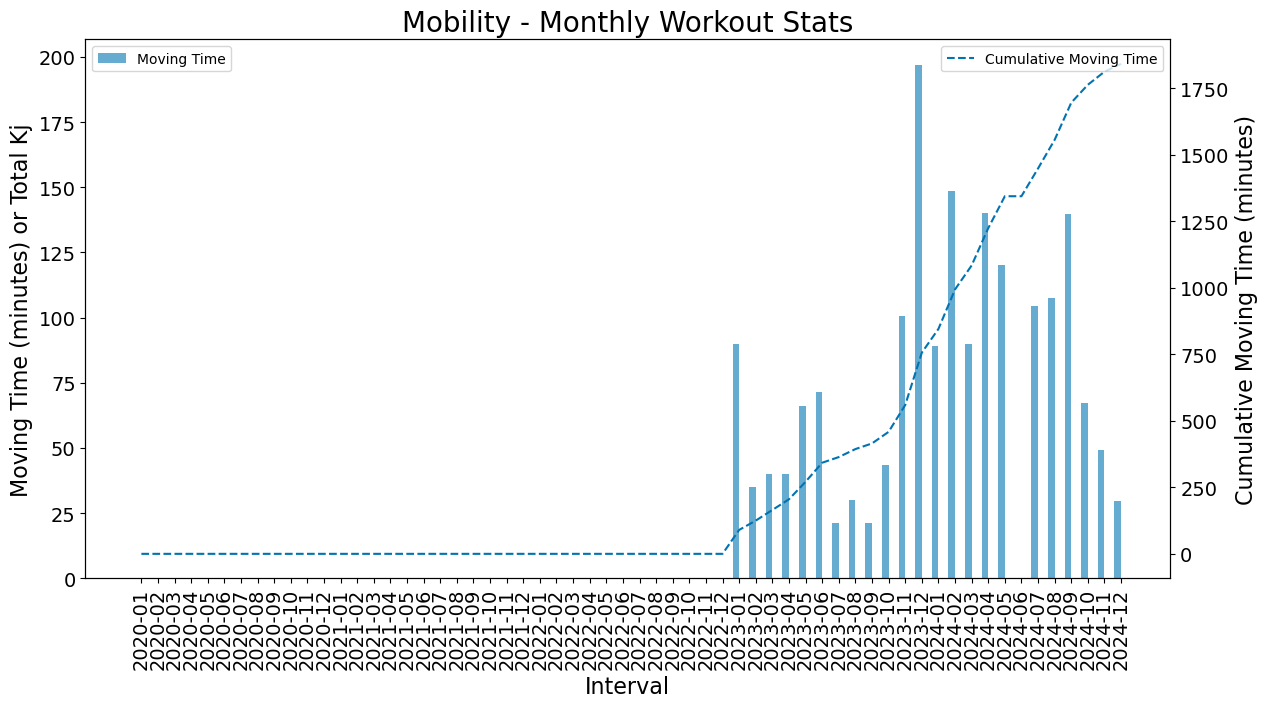

No Kilojoules


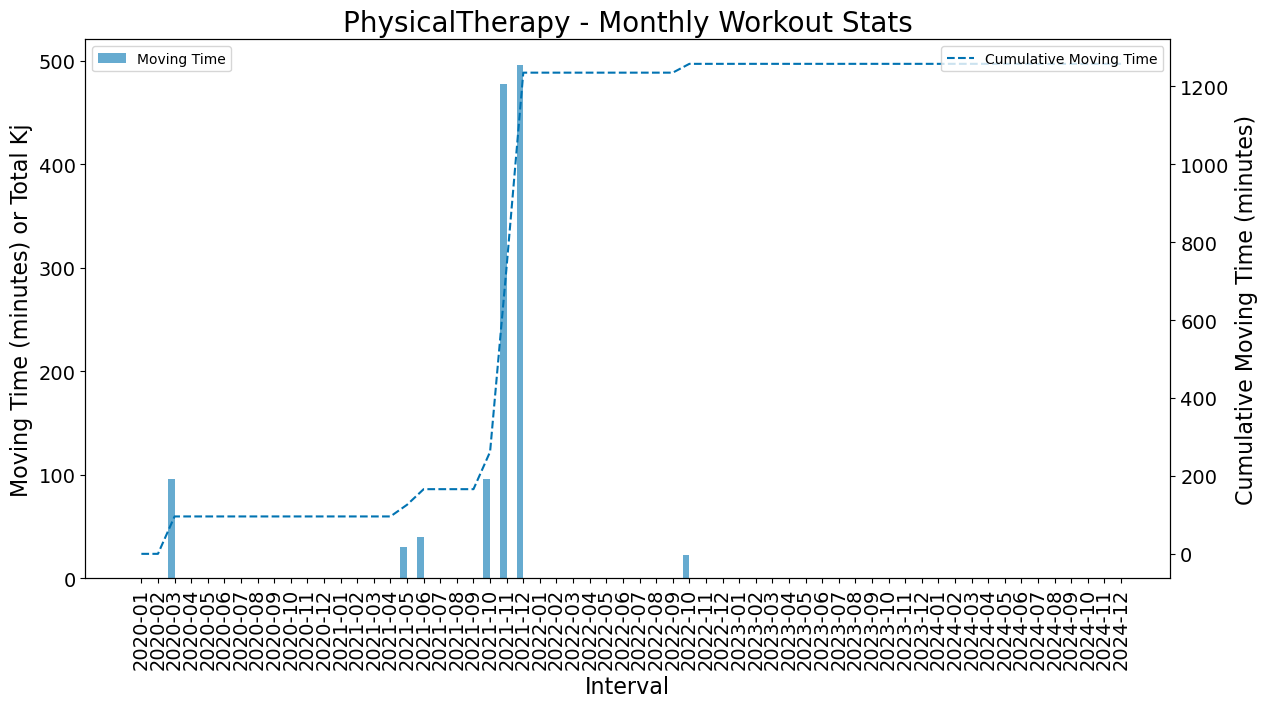

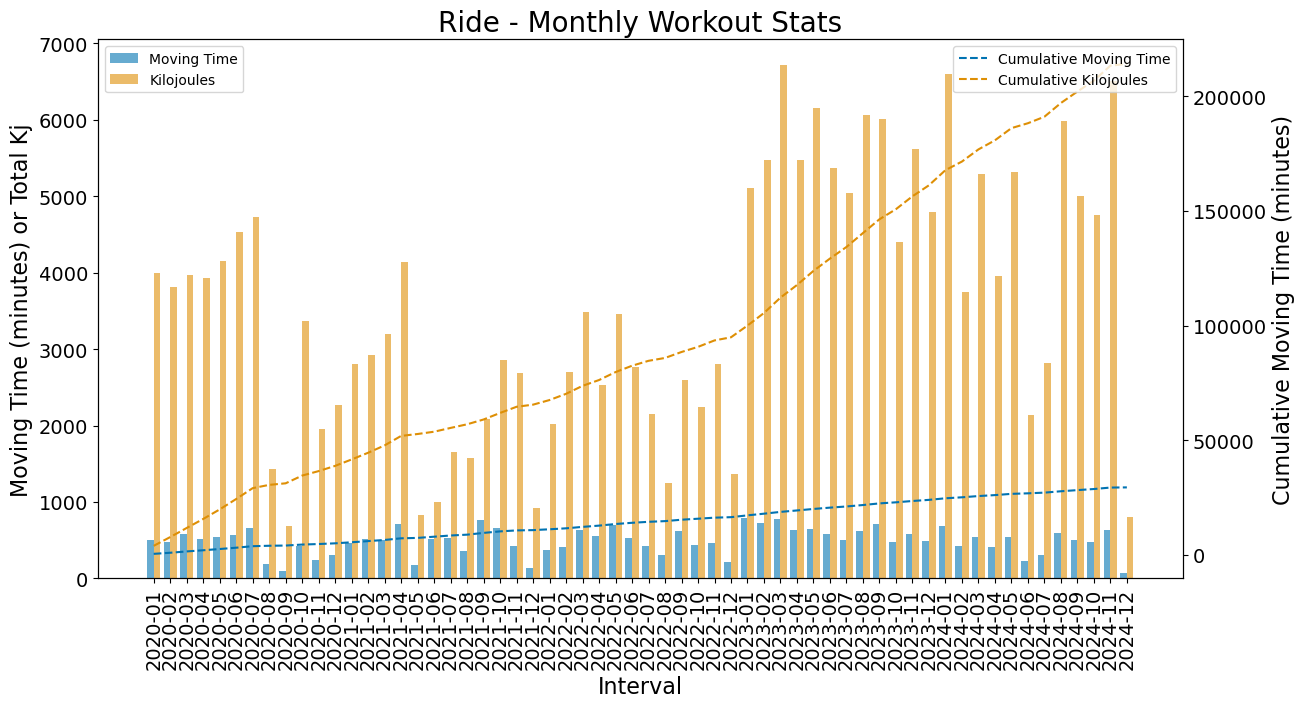

No Kilojoules


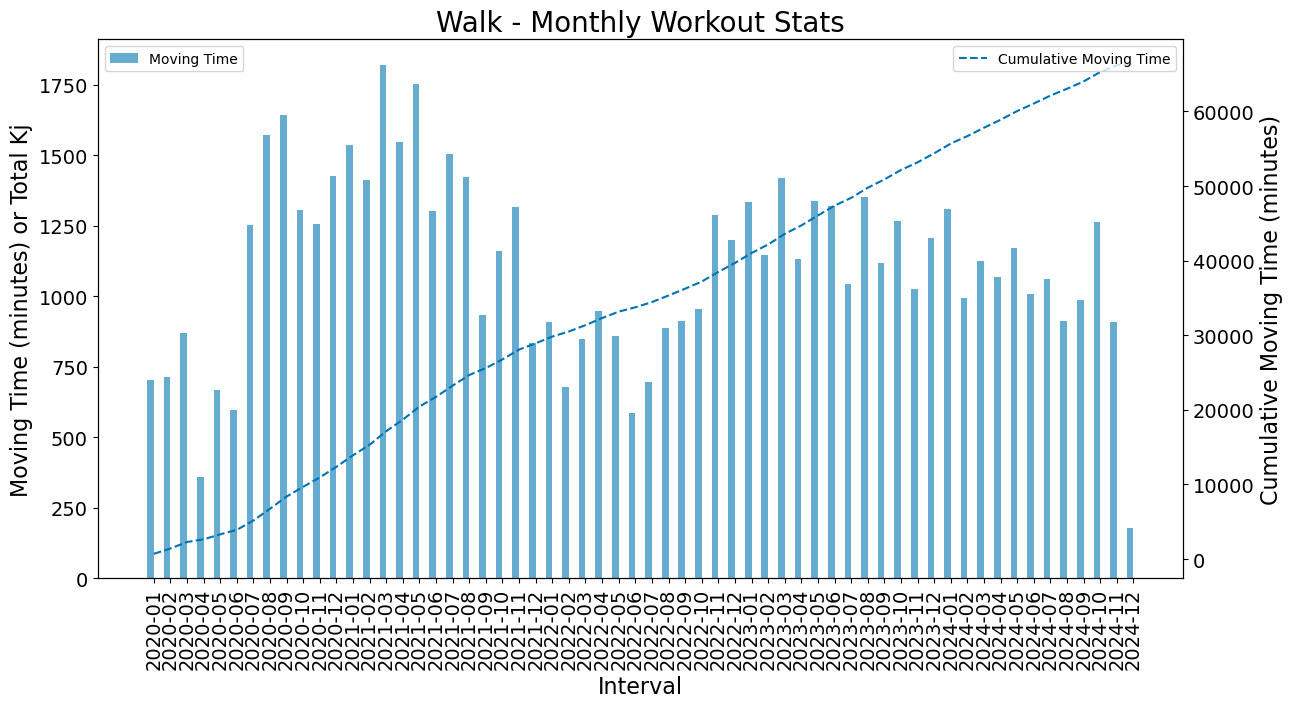

No Kilojoules


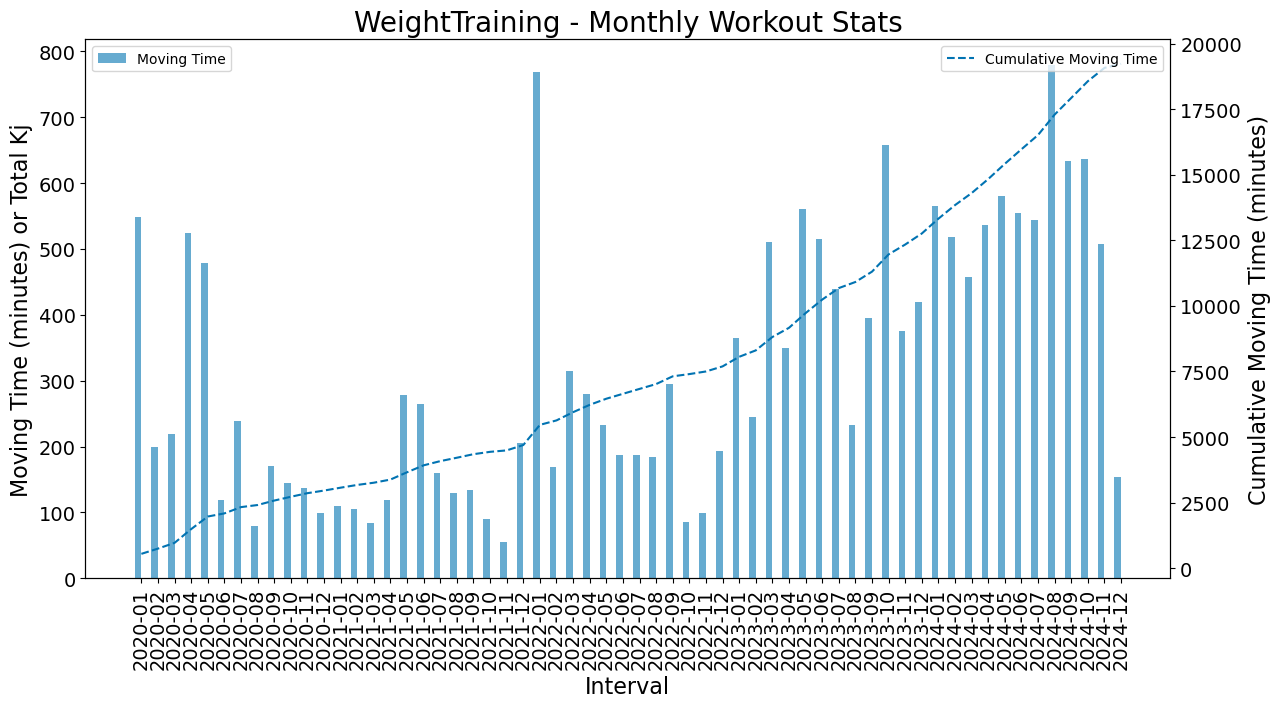

In [16]:
# Create combined bar chart and cumsum chart for each sport_type
# Create a common set of intervals
# Generate a complete range of weekly intervals
min_date = df_monthly_sub['start_date'].min()
max_date = df_monthly_sub['start_date'].max()
all_intervals = pd.date_range(start=min_date, end=max_date, freq='M').strftime('%Y-%m')

# Create combined bar chart and cumsum chart for each sport_type
for sport in df_monthly_sub['sport_type'].unique():
    df_sport = df_monthly_sub[df_monthly_sub['sport_type'] == sport]
    
    # Align intervals
    df_sport = df_sport.set_index('interval').reindex(all_intervals).reset_index().rename(columns={'index': 'interval'})
    df_sport['moving_time'] = df_sport['moving_time'].fillna(0)
    df_sport['kilojoules'] = df_sport['kilojoules'].fillna(0)
    df_sport['cumsum_moving_time'] = df_sport['cumsum_moving_time'].fillna(method='ffill').fillna(0)
    df_sport['cumsum_kilojoules'] = df_sport['cumsum_kilojoules'].fillna(method='ffill').fillna(0)
    
    fig, ax1 = plt.subplots(figsize=(14, 7))

    bar_width = 0.4
    intervals = range(len(all_intervals))

    # Bar chart for moving_time
    ax1.bar([i - bar_width/2 for i in intervals], df_sport['moving_time'], width=bar_width, alpha=0.6, label='Moving Time')
    ax1.set_xlabel('Interval')
    ax1.set_ylabel('Moving Time (minutes) or Total Kj')
    ax1.tick_params(axis='y')
    ax1.set_xticks(intervals)
    ax1.set_xticklabels(all_intervals, rotation=90)

    # Twin y-axis for cumulative sum of moving_time
    ax2 = ax1.twinx()
    ax2.plot(df_sport['interval'], df_sport['cumsum_moving_time'], linestyle='--', label='Cumulative Moving Time')
    ax2.set_ylabel('Cumulative Moving Time (minutes)')
    ax2.tick_params(axis='y')

    # Skip plotting kilojoules if the sum is 0
    if df_sport['kilojoules'].sum() == 0:
        print("No Kilojoules")
    else:
        # Bar chart for kilojoules
        ax1.bar([i + bar_width/2 for i in intervals], df_sport['kilojoules'], width=bar_width, alpha=0.6, label='Kilojoules')

        # Twin y-axis for cumulative sum of kilojoules
        ax2.plot(df_sport['interval'], df_sport['cumsum_kilojoules'], linestyle='--', label='Cumulative Kilojoules')

    # Add legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Set title
    plt.title(f'{sport} - Monthly Workout Stats')

    plt.show()

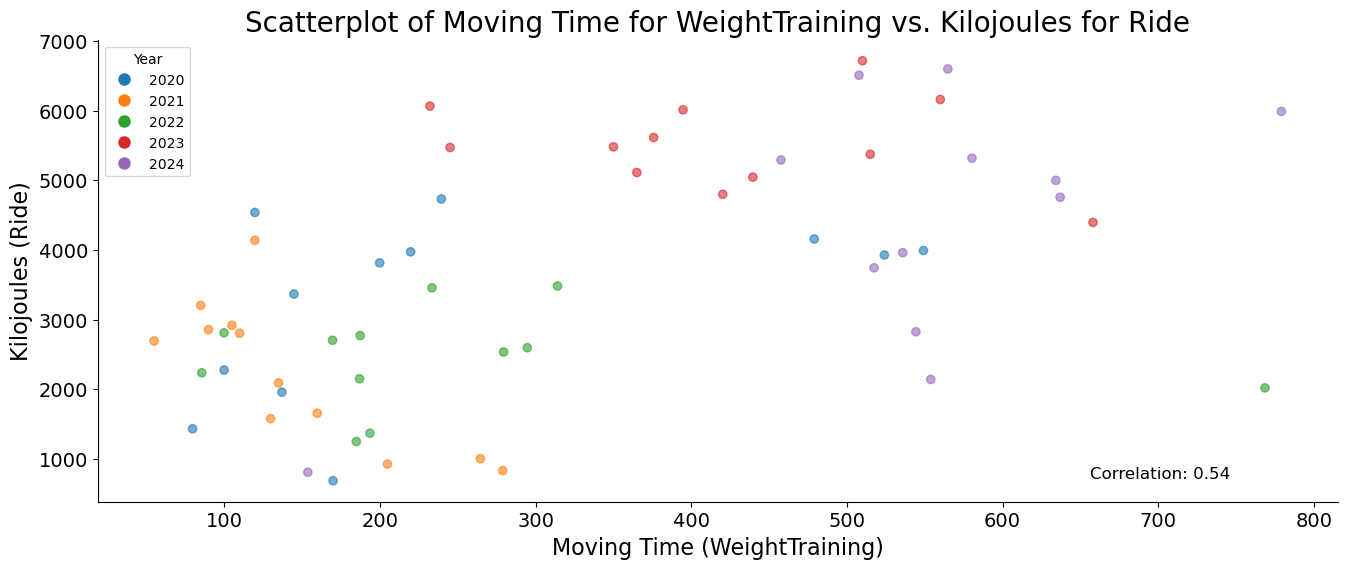

In [56]:
# Filter the data for the required sport types
df_weight_training = df_monthly_sub[df_monthly_sub['sport_type'] == 'WeightTraining']
df_ride = df_monthly_sub[df_monthly_sub['sport_type'] == 'Ride']

# Ensure both dataframes have the same intervals
common_intervals = df_weight_training['interval'].isin(df_ride['interval'])
df_weight_training = df_weight_training[common_intervals]
df_ride = df_ride[df_ride['interval'].isin(df_weight_training['interval'])]

# Extract the year from the interval
df_weight_training['year'] = pd.to_datetime(df_weight_training['interval']).dt.year
df_ride['year'] = pd.to_datetime(df_ride['interval']).dt.year

# Align the dataframes by interval
df_weight_training = df_weight_training.set_index('interval')
df_ride = df_ride.set_index('interval')
aligned_df = df_weight_training.join(df_ride, lsuffix='_wt', rsuffix='_ride', how='inner').reset_index()

# Define a colormap for the years using the first 5 colors from tab10
tab10 = plt.get_cmap('tab10')
year_color_map = {2020: tab10(0), 2021: tab10(1), 2022: tab10(2), 2023: tab10(3), 2024: tab10(4)}

# Map the colors to the years
colors = aligned_df['year_wt'].map(year_color_map)

# Calculate the correlation
correlation = aligned_df['moving_time_wt'].corr(aligned_df['kilojoules_ride'])

# Create the scatterplot
plt.figure(figsize=(16, 6))
scatter = plt.scatter(aligned_df['moving_time_wt'], aligned_df['kilojoules_ride'], c=colors, alpha=0.6)
plt.xlabel('Moving Time (WeightTraining)')
plt.ylabel('Kilojoules (Ride)')
plt.title('Scatterplot of Moving Time for WeightTraining vs. Kilojoules for Ride')
sns.despine(top=True, right=True)

# Annotate the correlation on the plot
plt.annotate(f'Correlation: {correlation:.2f}', xy=(0.80, 0.05), xycoords='axes fraction', fontsize=12, color='black', backgroundcolor='white')

# Create a custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=tab10(i), markersize=10, label=str(year)) for i, year in enumerate(year_color_map.keys())]
plt.legend(handles=handles, title='Year')
plt.savefig('../presentations/pictures/scatter_time_by_kj.png', dpi=300, bbox_inches='tight')
plt.show()

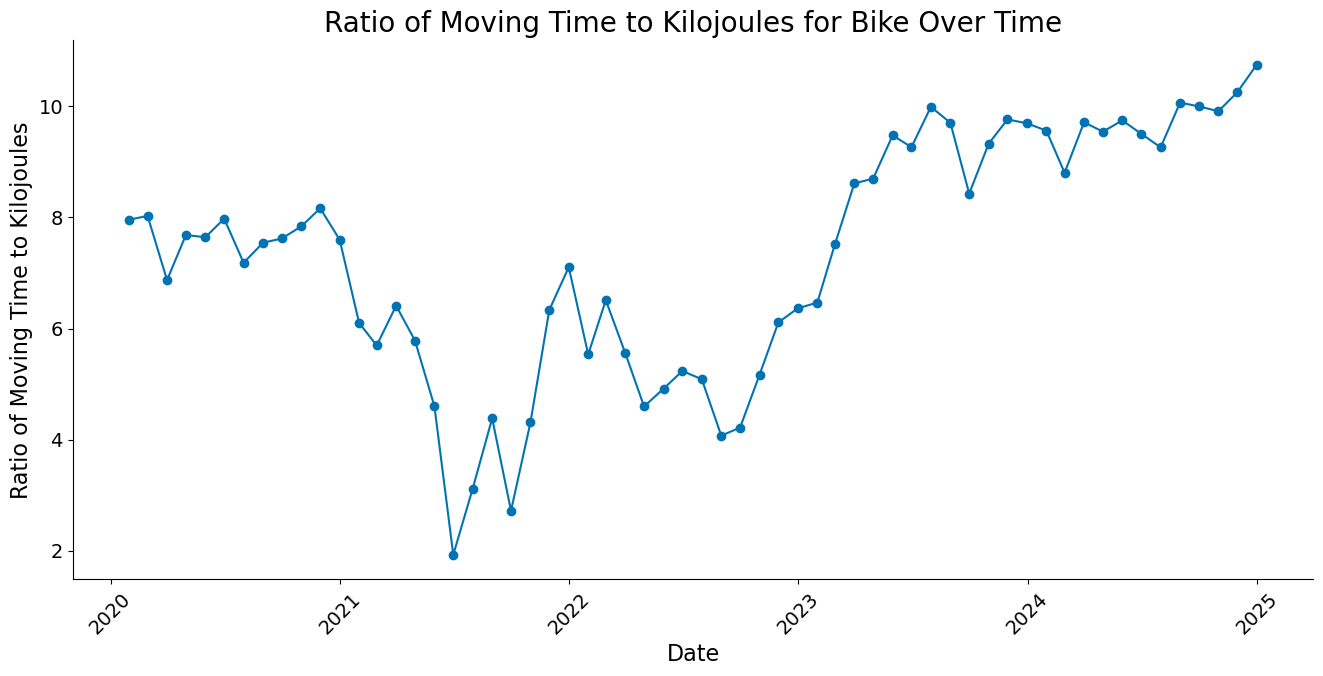

In [55]:

# Filter the data for sport_type == 'Bike'
df_bike = df_monthly_sub[df_monthly_sub['sport_type'] == 'Ride'].copy()
show(df_bike)
# Calculate the ratio of moving_time to kilojoules
df_bike['ratio'] = df_bike['kilojoules'] / df_bike['moving_time']
show(df_bike)

# Plot the ratio
plt.figure(figsize=(16, 7))
plt.plot(df_bike['start_date'], df_bike['ratio'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Ratio of Moving Time to Kilojoules')
plt.title('Ratio of Moving Time to Kilojoules for Bike Over Time')
plt.xticks(rotation=45)
sns.despine(right=True, top=True)
plt.savefig('../presentations/pictures/kilojoules_per_time.png', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
surgeries={
    '2001': 'pre-patellar bursa',
    '2014': 'shoulder repair',
    '2016': 'ankle spurs',
    '2022': 'knee surgeries'
}

weight={
    'Jan 2020': 259,
    'Jan 2021': 264,
    'Jan 2022': 240,
    'Jan 2023': 235,
    'Jan 2024': 221
}

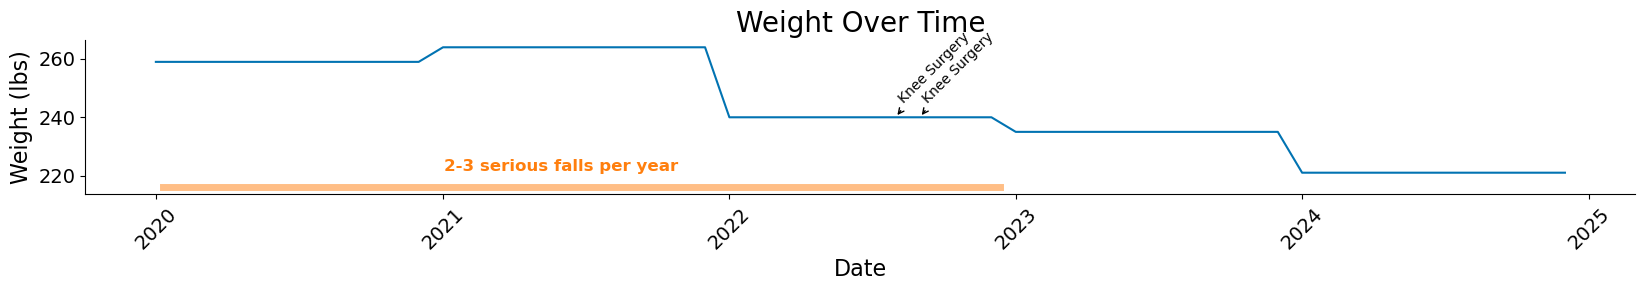

In [27]:
# Extract keys and values from the weight dictionary
weight_dates = list(weight.keys())
weight_values = list(weight.values())

# Convert weight_dates to datetime format
weight_dates = pd.to_datetime(weight_dates, format='%b %Y')

# Create a complete date range from Jan 1, 2020, to today
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime(datetime.today().strftime('%Y-%m-%d'))
date_range = pd.date_range(start=start_date, end=end_date, freq='MS')

# Create a DataFrame to hold the complete date range and corresponding weights
df = pd.DataFrame(date_range, columns=['date'])
df['weight'] = None

# Fill in the weights from the weight dictionary
for date, weight in zip(weight_dates, weight_values):
    df.loc[df['date'] == date, 'weight'] = weight

# Forward fill the weights to fill in the gaps
df['weight'] = df['weight'].ffill()

# Create a line plot
plt.figure(figsize=(20, 2))
plt.plot(df['date'], df['weight'], linestyle='-')
plt.xlabel('Date')
plt.ylabel('Weight (lbs)')
plt.title('Weight Over Time')
plt.xticks(rotation=45)
sns.despine(right=True, top=True)

# Add annotations for specific dates
annotations = {
    'Aug 2022': 'Knee Surgery',
    'Sep 2022': 'Knee Surgery'
}

for date_str, label in annotations.items():
    date = pd.to_datetime(date_str, format='%b %Y')
    if date in df['date'].values:
        weight_value = df.loc[df['date'] == date, 'weight'].values[0]
        plt.annotate(label, xy=(date, weight_value), 
                     xytext=(date - pd.DateOffset(months=0), weight_value + 5),
                     rotation=45,
                     arrowprops=dict(facecolor='black', arrowstyle='->'))
# Add a bar near the x-axis from 2020 to 2023
tab10 = plt.get_cmap('tab10')
second_color = tab10(1)
plt.axhline(y=df['weight'].min() - 5, xmin=0.05, xmax=0.59, linewidth=5, color=second_color, alpha=0.5)
plt.text(pd.to_datetime('2021-06-01'), df['weight'].min() + 0.5, '2-3 serious falls per year', color=second_color, fontsize=12, ha='center', fontweight='bold')
plt.savefig('../presentations/pictures/timeline.png', dpi=300, bbox_inches='tight')
plt.show()

